<a href="https://colab.research.google.com/github/SohamX1999/QSR-Sales-Forecasting/blob/main/Cluster_Forecasts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [263]:
df = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/Trilytics'24/sales_store_promotions.csv")

In [264]:
df.head()

STORE_KEY  STORE_NUMBERsales OPEN_DATEsales BUSINESS_DATE  \
0       1402                580     05-10-2011    03-02-2023   
1       2104               1323     21-11-2017    08-10-2022   
2       1753                969     06-02-2006    30-03-2023   
3       2443               1664     03-02-2020    07-03-2023   
4       1859               1078     11-03-2016    05-11-2022   

   TEMP_CLOSE_INDICATOR  PROJECTION_INCLUDED_INDICATOR  \
0                   0.0                              0   
1                   0.0                              0   
2                   0.0                              0   
3                   0.0                              0   
4                   0.0                              0   

   BUSINESS_DATE_FISCAL_DAY_OF_YEAR  BUSINESS_DATE_FISCAL_YEAR  \
0                                34                       2023   
1                               287                       2022   
2                                89                       2023   
3                                66                       2023   
4                               315                       2022   

   COMP_BUSINESS_DATE_FISCAL_YEAR  COMPARABLE_INDICATOR  ...  \
0                            2022                     1  ...   
1                            2021                     1  ...   
2                            2022                     1  ...   
3                            2022                     1  ...   
4                            2021                     1  ...   

   PROMOTION_START_DATE  PROMOTION_END_DATE  PLATFORM_DD  PLATFORM_Inhouse  \
0            03-02-2023          03-02-2023          0.0               0.0   
1                   NaN                 NaN          NaN               NaN   
2                   NaN                 NaN          NaN               NaN   
3            06-03-2023          12-03-2023          0.0               0.0   
4                   NaN                 NaN          NaN               NaN   

   PLATFORM_UE FREQUENCY_Weekday PromotionCash PromotionKind  \
0          1.0               0.0           0.0           1.0   
1          NaN               NaN           NaN           NaN   
2          NaN               NaN           NaN           NaN   
3          1.0               0.0           0.0           1.0   
4          NaN               NaN           NaN           NaN   

  PROMOTION_ITEM_DeliveryFee PROMOTION_COVERAGE_Regional  
0                        0.0                         0.0  
1                        NaN                         NaN  
2                        NaN                         NaN  
3                        0.0                         0.0  
4                        NaN                         NaN  

[5 rows x 58 columns]

In [265]:
promo_features = ['PLATFORM_DD',
       'PLATFORM_Inhouse', 'PLATFORM_UE', 'FREQUENCY_Weekday', 'PromotionCash',
       'PromotionKind', 'PROMOTION_ITEM_DeliveryFee',
       'PROMOTION_COVERAGE_Regional']

In [266]:
df[promo_features] = df[promo_features].fillna(0)
df[promo_features] = df[promo_features].astype(int)

In [267]:
df['BUSINESS_DATE'] = pd.to_datetime(df['BUSINESS_DATE'], format = '%d-%m-%Y')

In [268]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560021 entries, 0 to 560020
Data columns (total 58 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   STORE_KEY                         560021 non-null  int64         
 1   STORE_NUMBERsales                 560021 non-null  int64         
 2   OPEN_DATEsales                    560021 non-null  object        
 3   BUSINESS_DATE                     560021 non-null  datetime64[ns]
 4   TEMP_CLOSE_INDICATOR              329072 non-null  float64       
 5   PROJECTION_INCLUDED_INDICATOR     560021 non-null  int64         
 6   BUSINESS_DATE_FISCAL_DAY_OF_YEAR  560021 non-null  int64         
 7   BUSINESS_DATE_FISCAL_YEAR         560021 non-null  int64         
 8   COMP_BUSINESS_DATE_FISCAL_YEAR    560021 non-null  int64         
 9   COMPARABLE_INDICATOR              560021 non-null  int64         
 10  TRANSACTION_FINAL_COUNT         

In [269]:
# Forecast only for stores that we have enough data on (at least 90 days)
stores = df[df['BUSINESS_DATE'] <= '2023-07-04']['STORE_KEY'].unique()
df = df[df['STORE_KEY'].isin(stores)]

In [270]:
# Number of stores in each cluster
df[['STORE_KEY', 'Cluster']].groupby('Cluster').nunique()

STORE_KEY
Cluster           
0               20
1               87
2               57
3               65
4               86
5               73

In [271]:
# Define the special dates
downspike_dates = [
    '2019-11-28', '2020-11-26', '2021-11-25', '2022-11-24', '2023-11-23',  # Thanksgiving
    '2019-12-25', '2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25'   # Christmas
]
upspike_dates = [
    '2020-02-02', '2021-02-07', '2022-02-13', '2023-02-12'  # Super Bowl
]

# Convert to datetime
downspike_dates = pd.to_datetime(downspike_dates)
upspike_dates = pd.to_datetime(upspike_dates)

#<font color = red> The Get Cluster Data Function

In [274]:
from datetime import datetime

df['BUSINESS_DATE'] = pd.to_datetime(df['BUSINESS_DATE'])
df['UBER_EATS_MARKUP_DATE'] = pd.to_datetime(df['UBER_EATS_MARKUP_DATE'])
df['DOOR_DASH_MARKUP_GO_LIVE_DATE'] = pd.to_datetime(df['DOOR_DASH_MARKUP_GO_LIVE_DATE'])
df['STORE_LIVE_DATE'] = pd.to_datetime(df['STORE_LIVE_DATE'], format = "%d-%m-%Y")

def cluster_data(c_number):
  # Filter data for cluster
  cluster = df[df['Cluster'] == c_number]

  # Aggregate net sales by business date
  sales_time_series = cluster[['BUSINESS_DATE', 'NET_SALES_FINAL_USD_AMOUNT']].groupby('BUSINESS_DATE').sum()

  # Total number of stores in cluster
  total_stores_cluster = cluster['STORE_KEY'].nunique()

  # Calculate the percentage of stores on Uber Eats
  def calculate_ubereats_percentage(business_date):
      stores_on_ubereats = cluster[cluster['UBER_EATS_MARKUP_DATE'] <= business_date]['STORE_KEY'].nunique()
      return stores_on_ubereats / total_stores_cluster

  percentage_ubereats = round(sales_time_series.index.to_series().apply(calculate_ubereats_percentage)*100, 2)

  # Calculate the sum of the age of stores on Uber Eats
  cluster['ubereats_age'] = (pd.to_datetime('today') - pd.to_datetime(cluster['STORE_LIVE_DATE'])).dt.days
  cluster['ubereats_age'].fillna(0, inplace=True)
  cluster['ubereats_age'] = cluster['ubereats_age'].apply(lambda x: max(x, 0))  # Set negative values to zero  sum_ubereats_age = cluster.groupby('BUSINESS_DATE')['ubereats_age'].sum()
  sum_ubereats_age = cluster.groupby('BUSINESS_DATE')['ubereats_age'].sum()

  # Calculate the number of days on DoorDash
  cluster['doordash_age'] = (pd.to_datetime('today') - pd.to_datetime(cluster['DOOR_DASH_MARKUP_GO_LIVE_DATE'])).dt.days
  cluster['doordash_age'].fillna(0, inplace=True)
  cluster['doordash_age'] = cluster['doordash_age'].apply(lambda x: max(x, 0))  # Set negative values to zero

  # Calculate the number of days on Uber Eats
  cluster['ubereats_age_days'] = (pd.to_datetime('today') - pd.to_datetime(cluster['UBER_EATS_MARKUP_DATE'])).dt.days
  cluster['ubereats_age_days'].fillna(0, inplace=True)
  cluster['ubereats_age_days'] = cluster['ubereats_age_days'].apply(lambda x: max(x, 0))  # Set negative values to zero

  # Create a feature dataframe
  features = pd.DataFrame({
      'BUSINESS_DATE': sales_time_series.index,
      'percentage_ubereats': percentage_ubereats,
      'sum_ubereats_age': sum_ubereats_age,
      'day_of_year': sales_time_series.index.dayofyear,
      'doordash_age_days': cluster.groupby('BUSINESS_DATE')['doordash_age'].sum(),
      'ubereats_age_days': cluster.groupby('BUSINESS_DATE')['ubereats_age_days'].sum(),
      'py_net_sales': cluster.groupby('BUSINESS_DATE')['PY_NET_SALES_FINAL_USD_AMOUNT'].sum(),
      'PLATFORM_DD': cluster.groupby('BUSINESS_DATE')['PLATFORM_DD'].sum(),
      'PLATFORM_Inhouse': cluster.groupby('BUSINESS_DATE')['PLATFORM_Inhouse'].sum(),
      'PLATFORM_UE': cluster.groupby('BUSINESS_DATE')['PLATFORM_UE'].sum(),
      'FREQUENCY_Weekday': cluster.groupby('BUSINESS_DATE')['FREQUENCY_Weekday'].sum(),
      'PromotionCash': cluster.groupby('BUSINESS_DATE')['PromotionCash'].sum(),
      'PromotionKind': cluster.groupby('BUSINESS_DATE')['PromotionKind'].sum(),
      'PROMOTION_ITEM_DeliveryFee': cluster.groupby('BUSINESS_DATE')['PROMOTION_ITEM_DeliveryFee'].sum(),
      'PROMOTION_COVERAGE_Regional': cluster.groupby('BUSINESS_DATE')['PROMOTION_COVERAGE_Regional'].sum()
  }).set_index('BUSINESS_DATE')

  # Merge sales and feature data
  cluster_data = sales_time_series.merge(features, left_index = True, right_index = True)

  # Handling missing values (if any)
  cluster_data.fillna(0, inplace = True)

  # Check the prepared dataset
  return cluster_data

#<font color = red> Disaggregation: Simple Recent Proportions

In [275]:
def disaggregate(c_number, forecast_series, period):
  # Store the cluster level forecasts
  cluster_forecasts = pd.DataFrame(forecast_series)

  # Calculate total recent sales for each store
  recent_period = period
  recent_store_sales = df[df['Cluster'] == c_number].set_index('BUSINESS_DATE').last(recent_period).groupby('STORE_KEY')['NET_SALES_FINAL_USD_AMOUNT'].sum()

  # Calculate total recent sales for the cluster
  total_recent_sales = recent_store_sales.sum()

  # Calculate the proportion of sales for each store
  recent_store_proportions = recent_store_sales / total_recent_sales

  # Allocate forecasts to each store based on recent sales proportions
  recent_store_forecasts = pd.DataFrame(index = cluster_forecasts.index)

  for store_key, proportion in recent_store_proportions.items():
      recent_store_forecasts[store_key] = cluster_forecasts * proportion

  # recent_store_forecasts now contains the disaggregated forecasts for each store
  return recent_store_forecasts

#<font color = red> Disaggregation by Proportion Estimation: Random Forest

In [276]:
from sklearn.ensemble import RandomForestRegressor

def estimate_proportion_forecast(store_key):
  # Get Cluster Number
  c_no = df[df['STORE_KEY'] == store_key]['Cluster'].iloc[0]

  # Create cluster specific data
  cluster_df = df[df['Cluster'] == c_no]
  cluster_df['STORE_LIVE_DATE'] = pd.to_datetime(cluster_df['STORE_LIVE_DATE'])
  cluster_df['UBER_EATS_MARKUP_DATE'] = pd.to_datetime(cluster_df['UBER_EATS_MARKUP_DATE'])
  cluster_df['DOOR_DASH_MARKUP_GO_LIVE_DATE'] = pd.to_datetime(cluster_df['DOOR_DASH_MARKUP_GO_LIVE_DATE'])

  # Create features most likely influencing forecast proportions
  cluster_df['Store_Age'] = (pd.to_datetime(cluster_df['BUSINESS_DATE']) - pd.to_datetime(cluster_df['STORE_LIVE_DATE'])).dt.days  # Age of store as on Business Date
  cluster_df['Store_Age'].fillna(0, inplace = True)
  cluster_df['Store_Age'] = cluster_df['Store_Age'].apply(lambda x: max(x, 0))
  cluster_df['UE_Age'] = (pd.to_datetime(cluster_df['BUSINESS_DATE']) - pd.to_datetime(cluster_df['UBER_EATS_MARKUP_DATE'])).dt.days # No. of days on Uber Eats
  cluster_df['UE_Age'].fillna(0, inplace = True)
  cluster_df['UE_Age'] = cluster_df['UE_Age'].apply(lambda x: max(x, 0))  # Set negative values to zero
  cluster_df['DD_Age'] = (pd.to_datetime(cluster_df['BUSINESS_DATE']) - pd.to_datetime(cluster_df['DOOR_DASH_MARKUP_GO_LIVE_DATE'])).dt.days # No. of days on DoorDash
  cluster_df['DD_Age'].fillna(0, inplace = True)
  cluster_df['DD_Age'] = cluster_df['DD_Age'].apply(lambda x: max(x, 0))  # Set negative values to zero
  sales_by_date = cluster_df[['BUSINESS_DATE', 'NET_SALES_FINAL_USD_AMOUNT']].groupby('BUSINESS_DATE').sum()
  cluster_df = pd.merge(cluster_df, sales_by_date, how = 'left', on = 'BUSINESS_DATE')
  cluster_df['proportion'] = cluster_df['NET_SALES_FINAL_USD_AMOUNT_x'] / cluster_df['NET_SALES_FINAL_USD_AMOUNT_y']  # Proportion of cluster sales
  cluster_df['proportion'].fillna(0, inplace = True)

  # Extract data for only the particular store for which we are forecasting
  features = ['BUSINESS_DATE', 'BUSINESS_DATE_FISCAL_YEAR',
               'BUSINESS_DATE_FISCAL_DAY_OF_YEAR', 'PY_NET_SALES_FINAL_USD_AMOUNT',
               'Store_Age', 'UE_Age', 'DD_Age', 'proportion']

  cluster_df = cluster_df[cluster_df['STORE_KEY'] == store_key][features].sort_values('BUSINESS_DATE')

  # Divide the data
  forecast_horizon = 90
  X_train = cluster_df.drop(['BUSINESS_DATE', 'proportion'], axis = 1).iloc[:-forecast_horizon]
  y_train = cluster_df['proportion'].iloc[:-forecast_horizon]
  X_test = cluster_df.drop(['BUSINESS_DATE', 'proportion'], axis = 1).iloc[-forecast_horizon:]
  y_test = cluster_df['proportion'].iloc[-forecast_horizon:]

  # Standardize features
  # scaler = StandardScaler()
  # X_train[['Store_Age', 'UE_Age', 'DD_Age', 'PY_NET_SALES_FINAL_USD_AMOUNT']] = scaler.fit_transform(X_train[['Store_Age', 'UE_Age', 'DD_Age', 'PY_NET_SALES_FINAL_USD_AMOUNT']])
  # X_test[['Store_Age', 'UE_Age', 'DD_Age', 'PY_NET_SALES_FINAL_USD_AMOUNT']] = scaler.transform(X_test[['Store_Age', 'UE_Age', 'DD_Age', 'PY_NET_SALES_FINAL_USD_AMOUNT']])

  # Fit a model to predict proportion
  model = RandomForestRegressor(n_estimators = 100, max_depth = 5, random_state = 42)
  model.fit(X_train, y_train)
  model_fit = model.fit(X_train, y_train)
  forecast_proportions = model_fit.predict(X_test)

  # Create a DataFrame for the forecasts
  forecast_df = pd.DataFrame({
      'BUSINESS_DATE': X_test.index,
      'Forecast_Sales': forecast_proportions * cluster_forecasts[c_no]
  })

  # If proportion is negative, reset to 0
  forecast_df['Forecast_Sales'] = forecast_df['Forecast_Sales'].apply(lambda x: max(x, 0))

  return forecast_df

#<font color = blue> Cluster 0

In [156]:
cluster_0_data = cluster_data(0)
pd.concat([cluster_0_data.head(), cluster_0_data.tail()])

NET_SALES_FINAL_USD_AMOUNT  percentage_ubereats  \
BUSINESS_DATE                                                    
2019-04-23                        3919.07                  0.0   
2019-04-24                        3783.34                  0.0   
2019-04-25                        4283.50                  0.0   
2019-04-26                        5618.14                  0.0   
2019-04-27                        6005.14                  0.0   
2023-12-27                      113135.79                100.0   
2023-12-28                      115541.40                100.0   
2023-12-29                      137819.93                100.0   
2023-12-30                      142800.40                100.0   
2023-12-31                      146683.96                100.0   

               sum_ubereats_age  day_of_year  doordash_age_days  \
BUSINESS_DATE                                                     
2019-04-23                 5796          113               2790   
2019-04-24                 5796          114               2790   
2019-04-25                 5796          115               2790   
2019-04-26                 5796          116               2790   
2019-04-27                 5796          117               2790   
2023-12-27                21470          361              18462   
2023-12-28                21470          362              18462   
2023-12-29                21470          363              18462   
2023-12-30                21470          364              18462   
2023-12-31                21470          365              18462   

               ubereats_age_days  py_net_sales  PLATFORM_DD  PLATFORM_Inhouse  \
BUSINESS_DATE                                                                   
2019-04-23                  1468          0.00            0                 0   
2019-04-24                  1468          0.00            0                 0   
2019-04-25                  1468          0.00            0                 0   
2019-04-26                  1468          0.00            0                 0   
2019-04-27                  1468          0.00            0                 0   
2023-12-27                 14014      67781.52            0                 0   
2023-12-28                 14014      83540.88            0                 0   
2023-12-29                 14014      92120.76            0                 0   
2023-12-30                 14014     107368.93            0                 0   
2023-12-31                 14014      96276.71            0                 0   

               PLATFORM_UE  FREQUENCY_Weekday  PromotionCash  PromotionKind  \
BUSINESS_DATE                                                                 
2019-04-23               0                  0              0              0   
2019-04-24               0                  0              0              0   
2019-04-25               0                  0              0              0   
2019-04-26               0                  0              0              0   
2019-04-27               0                  0              0              0   
2023-12-27               0                  0              0              0   
2023-12-28               0                  0              0              0   
2023-12-29               0                  0              0              0   
2023-12-30               0                  0              0              0   
2023-12-31               0                  0              0              0   

               PROMOTION_ITEM_DeliveryFee  PROMOTION_COVERAGE_Regional  
BUSINESS_DATE                                                           
2019-04-23                              0                            0  
2019-04-24                              0                            0  
2019-04-25                              0                            0  
2019-04-26                              0                            0  
2019-04-27                              0                

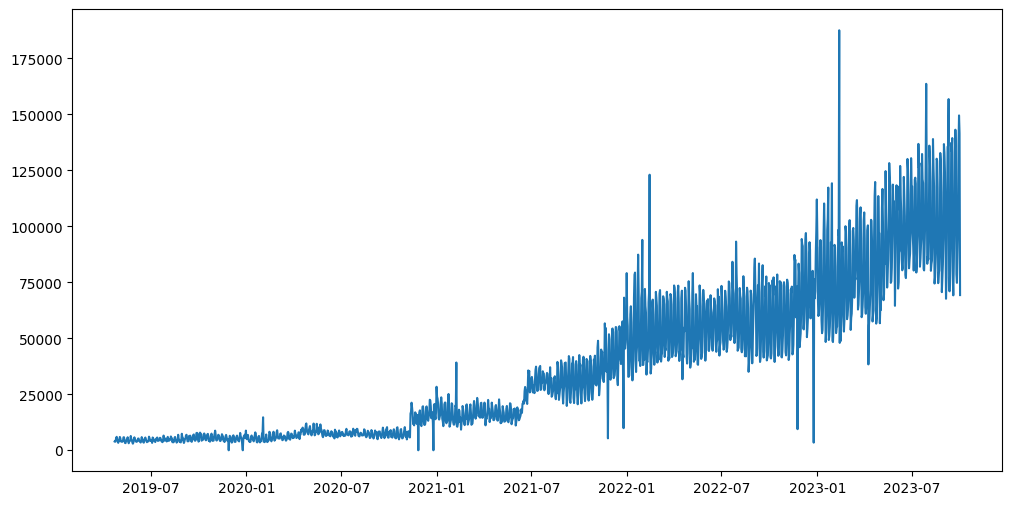

In [157]:
# Split data into train and test sets
train = cluster_0_data.iloc[:-90]  # Assuming the last 90 days are for testing
test = cluster_0_data.iloc[-90:]

plt.figure(figsize = (12, 6))
plt.plot(train['NET_SALES_FINAL_USD_AMOUNT'])

In [158]:
# Normalize all but indicator features
columns = ['percentage_ubereats', 'sum_ubereats_age',
       'day_of_year', 'doordash_age_days', 'ubereats_age_days', 'py_net_sales']
scaler = StandardScaler()
train[columns] = scaler.fit_transform(train[columns])
test[columns] = scaler.transform(test[columns])

##<font color = magenta> ACF-PACF Analysis

<Figure size 1000x500 with 0 Axes>

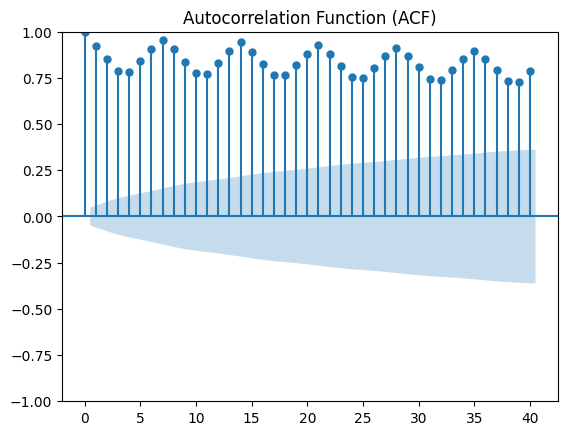

<Figure size 1000x500 with 0 Axes>

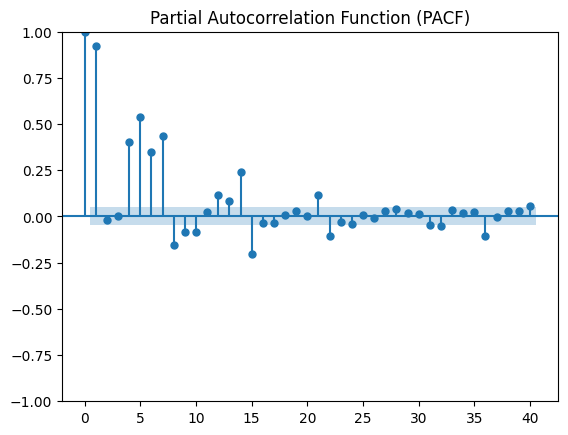

In [159]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Extract the sales time series
sales = train['NET_SALES_FINAL_USD_AMOUNT']

# Plot ACF
plt.figure(figsize = (10, 5))
plot_acf(sales, lags = 40, alpha = 0.05)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize = (10, 5))
plot_pacf(sales, lags = 40, alpha = 0.05, method = 'ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

<Figure size 1000x500 with 0 Axes>

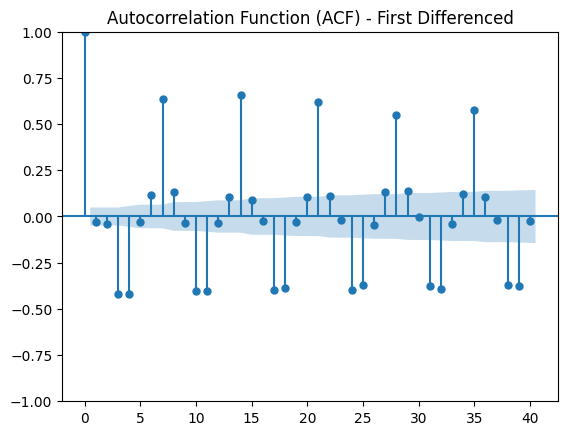

<Figure size 1000x500 with 0 Axes>

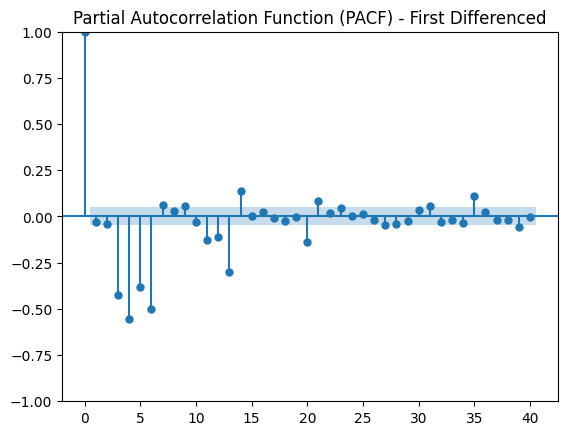

In [160]:
# Compute the first difference
sales_diff = sales.diff().dropna()

# Plot ACF for first differenced data
plt.figure(figsize = (10, 5))
plot_acf(sales_diff, lags = 40, alpha = 0.05)
plt.title('Autocorrelation Function (ACF) - First Differenced')
plt.show()

# Plot PACF for first differenced data
plt.figure(figsize = (10, 5))
plot_pacf(sales_diff, lags = 40, alpha = 0.05, method = 'ywm')
plt.title('Partial Autocorrelation Function (PACF) - First Differenced')
plt.show()

##<font color = magenta> SARIMAX

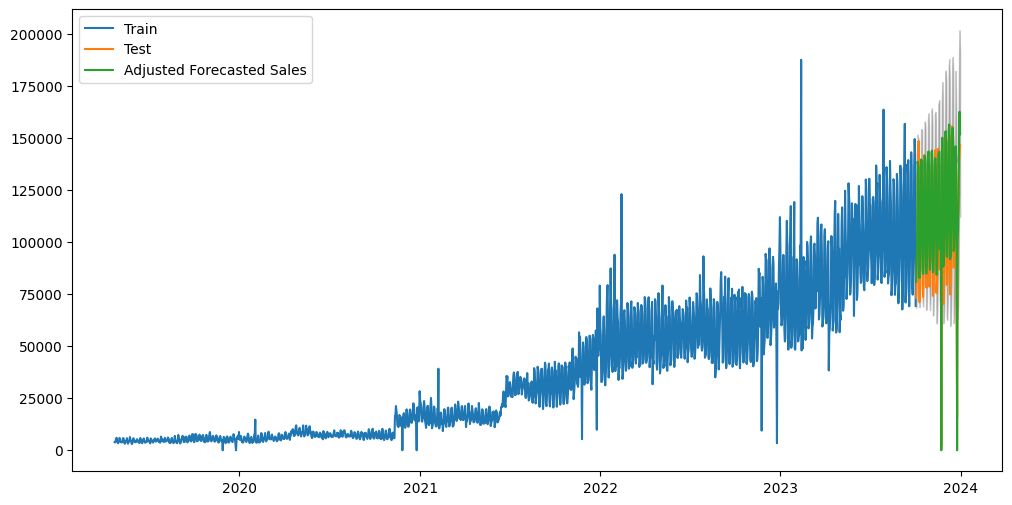

In [161]:
exog_vars = ['percentage_ubereats', 'sum_ubereats_age', 'day_of_year',
             'doordash_age_days', 'ubereats_age_days', 'py_net_sales', 'PLATFORM_DD',
       'PLATFORM_Inhouse', 'PLATFORM_UE', 'FREQUENCY_Weekday', 'PromotionCash',
       'PromotionKind', 'PROMOTION_ITEM_DeliveryFee',
       'PROMOTION_COVERAGE_Regional']

# Fit the SARIMAX model
model = SARIMAX(train['NET_SALES_FINAL_USD_AMOUNT'],
                exog = train[exog_vars],
                order = (0, 1, 1), seasonal_order = (0, 1, 1, 7))
model_fit = model.fit(disp = False)

# Forecast
forecast = model_fit.get_forecast(steps = len(test),
                                  exog = test[exog_vars])

forecast_conf = forecast.conf_int()
forecast_series = forecast.predicted_mean

# Create a DataFrame for the forecasts
forecast_df = pd.DataFrame({
    'BUSINESS_DATE': test.index,
    'Predicted_Sales': forecast_series
})

# Initialize the adjusted predictions with the original forecasts
adjusted_forecast = forecast_series.copy()

# Adjust the forecasts based on special dates
for i in range(len(forecast_df)):
    date = forecast_df['BUSINESS_DATE'].iloc[i]

    if date in downspike_dates:
        adjusted_forecast[i] = 0 # Set downspikes sales to zero
    elif date in upspike_dates:
        if i > 0:
            adjusted_forecast[i] = adjusted_forecast[i-1] + forecast_series[i]  # Add the forecasted value to the previous value for upspike dates
    else:
        adjusted_forecast[i] = forecast_series[i]  # Keep the original forecast for other dates

# Create a DataFrame for the adjusted predictions
adjusted_predictions_df = pd.DataFrame({
    'BUSINESS_DATE': forecast_df['BUSINESS_DATE'],
    'Adjusted_Predicted_Sales': adjusted_forecast
})

# Plot the results
plt.figure(figsize = (12, 6))
plt.plot(train['NET_SALES_FINAL_USD_AMOUNT'], label = 'Train')
plt.plot(test['NET_SALES_FINAL_USD_AMOUNT'], label = 'Test')
plt.plot(adjusted_predictions_df['BUSINESS_DATE'], adjusted_predictions_df['Adjusted_Predicted_Sales'], label='Adjusted Forecasted Sales')
#plt.plot(forecast_series, label = 'Forecast')
plt.fill_between(forecast_conf.index, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1],
                 color = 'k', alpha = 0.2)
plt.legend()
plt.show()

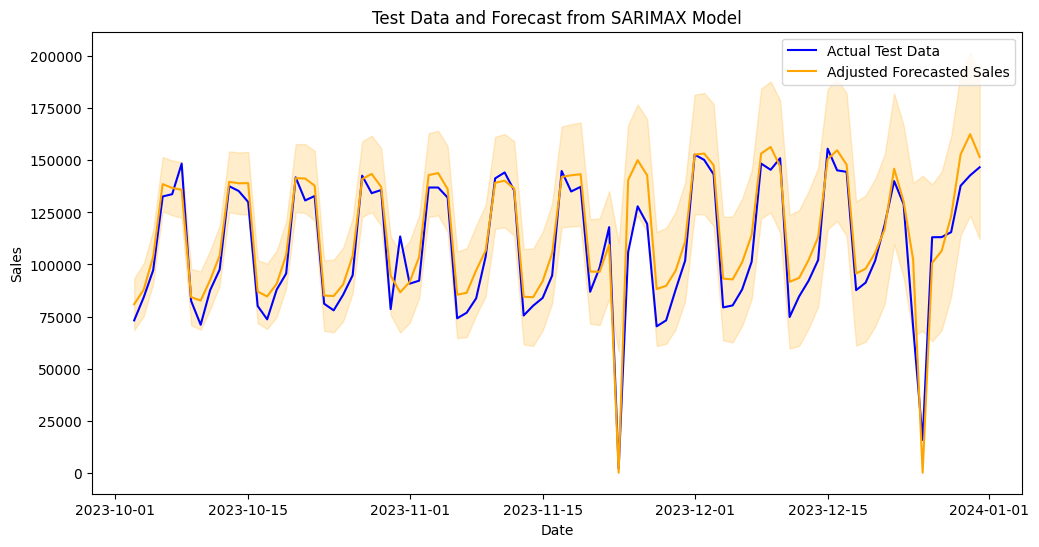

In [162]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['NET_SALES_FINAL_USD_AMOUNT'], label = 'Actual Test Data', color = 'blue')
plt.plot(adjusted_predictions_df['BUSINESS_DATE'], adjusted_predictions_df['Adjusted_Predicted_Sales'],
         label='Adjusted Forecasted Sales', color = 'orange')
plt.fill_between(test.index, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1],
                 color = 'orange', alpha = 0.2)
plt.title('Test Data and Forecast from SARIMAX Model')
plt.xlabel('Date')
plt.ylabel('Sales')
#plt.axvline(x = test[test.index == '2023-11-23'].index, color = 'red')
#plt.axvline(x = test[test.index == '2023-12-25'].index, color = 'red')
plt.legend()
plt.show()

In [163]:
# Define dates to exclude
exclude_dates = pd.to_datetime(['2023-11-23', '2023-12-25'])

# Filter out the excluded dates
mask = ~test.index.isin(exclude_dates)

actual = test['NET_SALES_FINAL_USD_AMOUNT']
actual_excl = test.loc[mask, 'NET_SALES_FINAL_USD_AMOUNT']

mape = np.mean(np.abs((actual - adjusted_predictions_df['Adjusted_Predicted_Sales']) / actual)) * 100
print(f"MAPE: {mape:.2f}%")

smape = np.mean(np.abs((actual - adjusted_predictions_df['Adjusted_Predicted_Sales']) / (actual + adjusted_predictions_df['Adjusted_Predicted_Sales'])) * 200)
print(f"sMAPE: {smape:.2f}%")

mape_excl = np.mean(np.abs((actual_excl - adjusted_predictions_df['Adjusted_Predicted_Sales'][mask]) / actual_excl)) * 100
print(f"MAPE excluding the 2 spikes: {mape_excl:.2f}%")

MAPE: 10.73%
sMAPE: 12.46%
MAPE excluding the 2 spikes: 8.70%


In [164]:
cluster_forecasts = []
cluster_forecasts.append(adjusted_predictions_df['Adjusted_Predicted_Sales'])

##<font color = magenta> Disaggregation: Simple Recent Proportions

In [165]:
disaggregated_forecasts = disaggregate(c_number = 0,
                                       forecast_series = adjusted_predictions_df['Adjusted_Predicted_Sales'],
                                       period = '1Y')
pd.concat([disaggregated_forecasts.head(), disaggregated_forecasts.tail()])

71           116          178          184           217   \
2023-10-03   5460.272024  3141.348972  4244.023194  4484.711932   6664.173240   
2023-10-04   5927.970883  3410.420792  4607.544425  4868.849324   7234.992093   
2023-10-05   6991.126764  4022.064977  5433.887545  5742.056345   8532.556564   
2023-10-06   9350.941964  5379.690206  7268.065476  7680.254907  11412.672653   
2023-10-07   9226.983953  5308.375925  7171.718504  7578.443868  11261.383916   
2023-12-27   7184.377231  4133.243899  5584.092417  5900.779696   8768.415617   
2023-12-28   8311.221821  4781.528834  6459.937898  6826.296476  10143.711120   
2023-12-29  10314.213240  5933.869781  8016.772796  8471.423216  12588.329585   
2023-12-30  10969.193983  6310.686737  8525.859789  9009.381754  13387.722934   
2023-12-31  10232.116304  5886.638595  7952.962550  8403.994138  12488.131610   

                    221          283          342           348   \
2023-10-03   7229.426833  3671.904227  2874.863095   5642.223002   
2023-10-04   7848.662407  3986.420685  3121.109103   6125.506847   
2023-10-05   9256.285988  4701.367955  3680.866492   7224.089948   
2023-10-06  12380.692840  6288.288051  4923.322106   9662.540550   
2023-10-07  12216.571828  6204.929211  4858.057535   9534.451924   
2023-12-27   9512.150549  4831.324338  3782.613920   7423.780041   
2023-12-28  11004.098291  5589.100763  4375.903762   8588.174130   
2023-12-29  13656.068714  6936.065278  5430.489703  10657.910620   
2023-12-30  14523.266418  7376.524388  5775.340648  11334.717087   
2023-12-31  13547.371970  6880.857024  5387.265217  10573.077993   

                    366          373          377          390          449   \
2023-10-03   6332.658573  2228.150147  4034.906902   829.126625  1665.645277   
2023-10-04   6875.081583  2419.002046  4380.516305   900.145354  1808.315896   
2023-10-05   8108.097663  2852.839577  5166.142916  1061.582521  2132.629514   
2023-10-06  10844.940057  3815.799401  6909.945165  1419.913682  2852.486515   
2023-10-07  10701.177300  3765.216379  6818.345510  1401.091014  2814.673366   
2023-12-27   8332.223718  2931.698479  5308.946724  1090.927050  2191.580190   
2023-12-28   9639.104038  3391.525192  6141.636560  1262.035164  2535.321923   
2023-12-29  11962.112988  4208.877442  7621.761335  1566.183659  3146.330529   
2023-12-30  12721.739871  4476.152668  8105.764020  1665.640604  3346.131120   
2023-12-31  11866.899442  4175.376493  7561.095219  1553.717475  3121.287019   

                   524          569          650          666           1635  \
2023-10-03  2161.513649  1074.866089  1866.604819  2159.300853   7458.703333   
2023-10-04  2346.657807  1166.933598  2026.488601  2344.255474   8097.577555   
2023-10-05  2767.520713  1376.218080  2389.930548  2764.687532   9549.842988   
2023-10-06  3701.681638  1840.752690  3196.638054  3697.892133  12773.338342   
2023-10-07  3652.611384  1816.351294  3154.262762  3648.872113  12604.012340   
2023-12-27  2844.021209  1414.259843  2455.993603  2841.109713   9813.822126   
2023-12-28  3290.096048  1636.081582  2841.207661  3286.727893  11353.086006   
2023-12-29  4083.004034  2030.374677  3525.934249  4078.824159  14089.161920   
2023-12-30  4342.285954  2159.309021  3749.840715  4337.840646  14983.862227   
2023-12-31  4050.504985  2014.213722  3497.869249  4046.358380  13977.017931   

                    2222  
2023-10-03   7710.454381  
2023-10-04   8370.892304  
2023-10-05   9872.175554  
2023-10-06  13204.472437  
2023-10-07  13029.431233  
2023-12-27  10145.064688  
2023-12-28  11736.282812  
2023-12-29  14564.708556  
2023-12-30  15489.607374  
2023-12-31  14448.779409

In [166]:
# Select a random store_key from the list of store keys
random_store_key = random.choice(list(disaggregated_forecasts.columns))
print(f"Randomly selected store_key: {random_store_key}")

Randomly selected store_key: 342


In [167]:
# Extract actual sales for the selected store
actual_sales = df[df['STORE_KEY'] == random_store_key].set_index('BUSINESS_DATE')['NET_SALES_FINAL_USD_AMOUNT'].sort_index()[-90:]

# Extract forecasted sales for the selected store
forecasted_sales = disaggregated_forecasts[random_store_key]

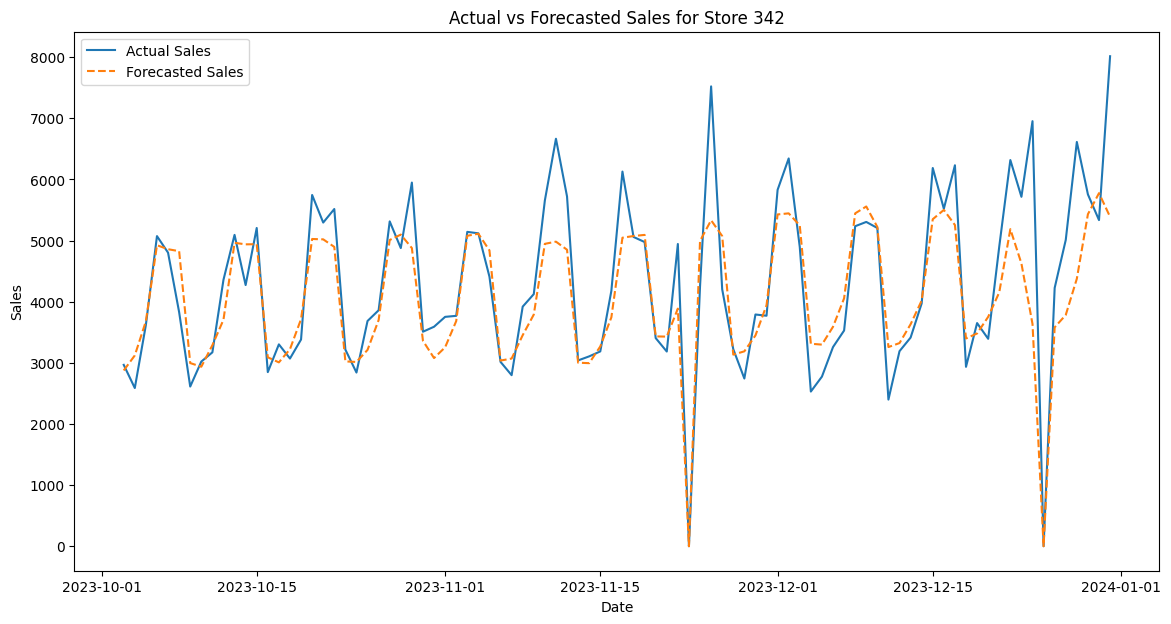

In [168]:
# Combine actual and forecasted sales into a single DataFrame
combined_sales = pd.concat([actual_sales, forecasted_sales], axis=1)
combined_sales.columns = ['Actual Sales', 'Forecasted Sales']

# Plot the actual and forecasted sales
plt.figure(figsize = (14, 7))
plt.plot(combined_sales['Actual Sales'], label = 'Actual Sales')
plt.plot(combined_sales['Forecasted Sales'], label = 'Forecasted Sales', linestyle = '--')
plt.title(f'Actual vs Forecasted Sales for Store {random_store_key}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#<font color = blue> Cluster 1

In [169]:
cluster_1_data = cluster_data(1)
pd.concat([cluster_1_data.head(), cluster_1_data.tail()])

NET_SALES_FINAL_USD_AMOUNT  percentage_ubereats  \
BUSINESS_DATE                                                    
2019-04-23                      164937.31                11.49   
2019-04-24                      172761.62                11.49   
2019-04-25                      199593.76                11.49   
2019-04-26                      270427.59                11.49   
2019-04-27                      250594.37                11.49   
2023-12-27                      507207.75               100.00   
2023-12-28                      522995.96               100.00   
2023-12-29                      640604.76               100.00   
2023-12-30                      626314.64               100.00   
2023-12-31                      606445.44               100.00   

               sum_ubereats_age  day_of_year  doordash_age_days  \
BUSINESS_DATE                                                     
2019-04-23               215159          113              99080   
2019-04-24               215159          114              99080   
2019-04-25               215159          115              99080   
2019-04-26               215159          116              99080   
2019-04-27               215159          117              99080   
2023-12-27               240679          361             120997   
2023-12-28               240679          362             120997   
2023-12-29               240679          363             120997   
2023-12-30               240679          364             120997   
2023-12-31               240679          365             120997   

               ubereats_age_days  py_net_sales  PLATFORM_DD  PLATFORM_Inhouse  \
BUSINESS_DATE                                                                   
2019-04-23                 79677          0.00            0                 0   
2019-04-24                 79677          0.00            0                 0   
2019-04-25                 79677          0.00            0                 0   
2019-04-26                 79677          0.00            0                 0   
2019-04-27                 79677          0.00            0                 0   
2023-12-27                 93385     411047.71            0                 0   
2023-12-28                 93385     475691.58            0                 0   
2023-12-29                 93385     559673.60            0                 0   
2023-12-30                 93385     567371.27            0                 0   
2023-12-31                 93385     524513.72            0                 0   

               PLATFORM_UE  FREQUENCY_Weekday  PromotionCash  PromotionKind  \
BUSINESS_DATE                                                                 
2019-04-23               0                  0              0              0   
2019-04-24               0                  0              0              0   
2019-04-25               0                  0              0              0   
2019-04-26               0                  0              0              0   
2019-04-27               0                  0              0              0   
2023-12-27               0                  0              0              0   
2023-12-28               0                  0              0              0   
2023-12-29               0                  0              0              0   
2023-12-30               0                  0              0              0   
2023-12-31               0                  0              0              0   

               PROMOTION_ITEM_DeliveryFee  PROMOTION_COVERAGE_Regional  
BUSINESS_DATE                                                           
2019-04-23                              0                            0  
2019-04-24                              0                            0  
2019-04-25                              0                            0  
2019-04-26                              0                            0  
2019-04-27                              0                

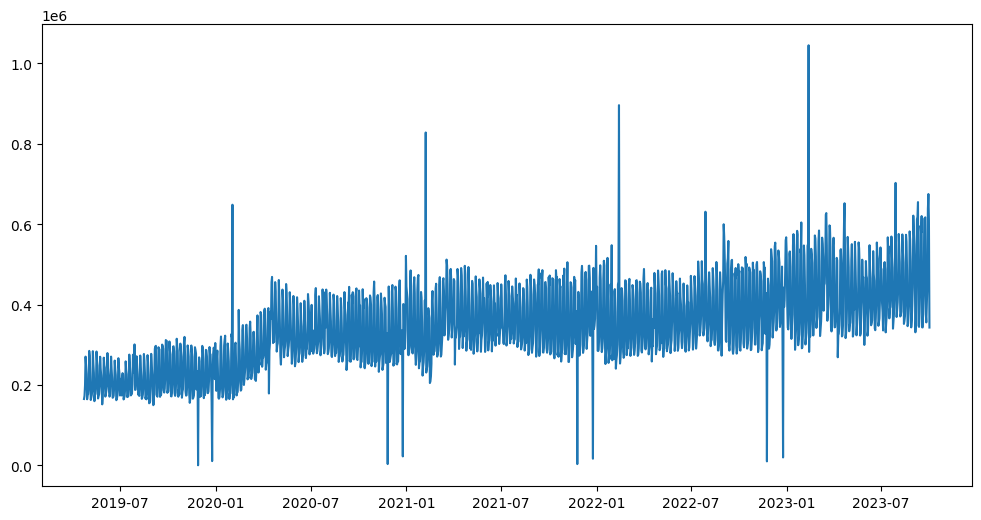

In [170]:
# Split data into train and test sets
train = cluster_1_data.iloc[:-90]  # Assuming the last 90 days are for testing
test = cluster_1_data.iloc[-90:]

plt.figure(figsize = (12, 6))
plt.plot(train['NET_SALES_FINAL_USD_AMOUNT'])

In [171]:
# Normalize all but indicator features
columns = ['percentage_ubereats', 'sum_ubereats_age',
       'day_of_year', 'doordash_age_days', 'ubereats_age_days', 'py_net_sales']
scaler = StandardScaler()
train[columns] = scaler.fit_transform(train[columns])
test[columns] = scaler.transform(test[columns])

##<font color = magenta> ACF-PACF Analysis

<Figure size 1000x500 with 0 Axes>

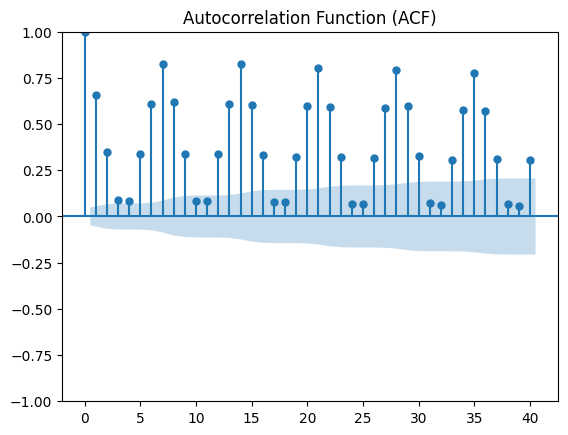

<Figure size 1000x500 with 0 Axes>

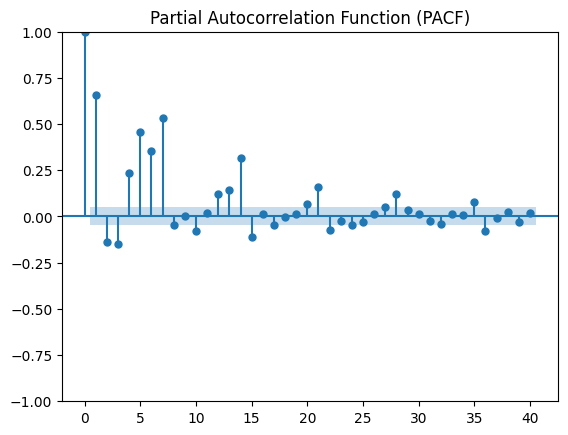

In [172]:
# Extract the sales time series
sales = train['NET_SALES_FINAL_USD_AMOUNT']

# Plot ACF
plt.figure(figsize = (10, 5))
plot_acf(sales, lags = 40, alpha = 0.05)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize = (10, 5))
plot_pacf(sales, lags = 40, alpha = 0.05, method = 'ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

<Figure size 1000x500 with 0 Axes>

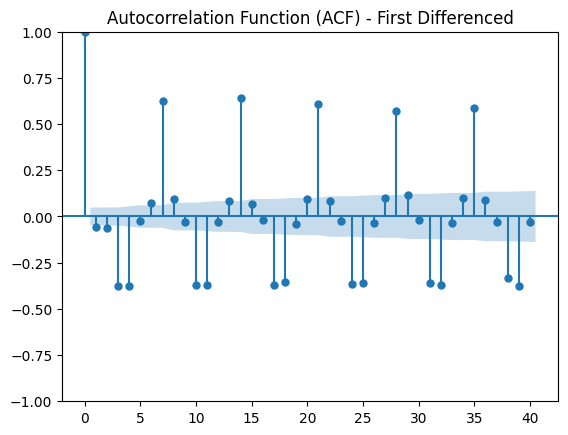

<Figure size 1000x500 with 0 Axes>

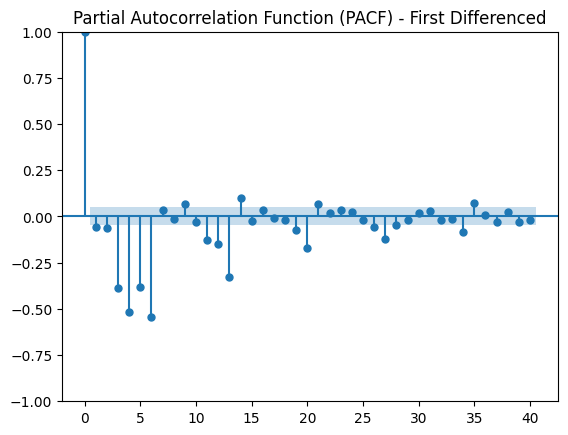

In [173]:
# Compute the first difference
sales_diff = sales.diff().dropna()

# Plot ACF for first differenced data
plt.figure(figsize = (10, 5))
plot_acf(sales_diff, lags = 40, alpha = 0.05)
plt.title('Autocorrelation Function (ACF) - First Differenced')
plt.show()

# Plot PACF for first differenced data
plt.figure(figsize = (10, 5))
plot_pacf(sales_diff, lags = 40, alpha = 0.05, method = 'ywm')
plt.title('Partial Autocorrelation Function (PACF) - First Differenced')
plt.show()

##<font color = magenta> SARIMAX

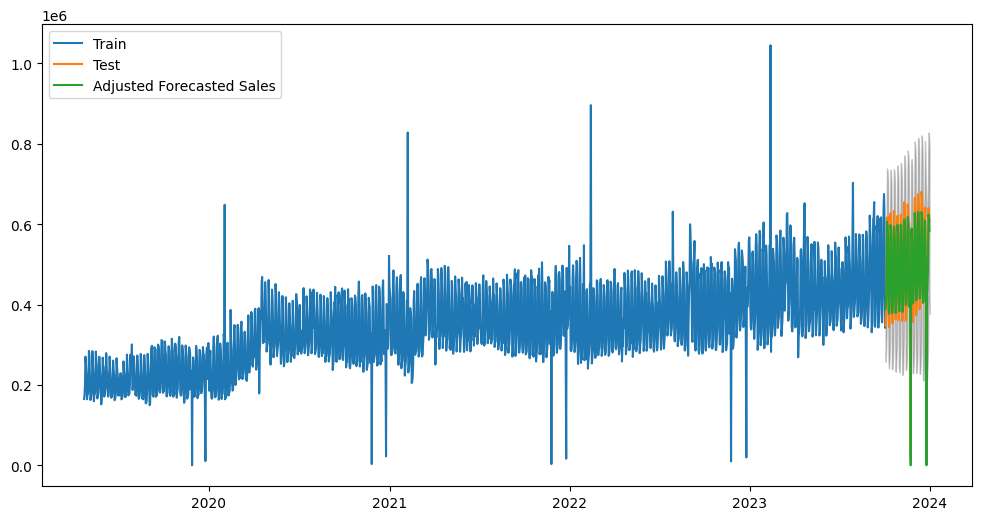

In [174]:
exog_vars = ['percentage_ubereats', 'sum_ubereats_age', 'day_of_year',
             'doordash_age_days', 'ubereats_age_days', 'py_net_sales', 'PLATFORM_DD',
       'PLATFORM_Inhouse', 'PLATFORM_UE', 'FREQUENCY_Weekday', 'PromotionCash',
       'PromotionKind', 'PROMOTION_ITEM_DeliveryFee',
       'PROMOTION_COVERAGE_Regional']

# Fit the SARIMAX model
model = SARIMAX(train['NET_SALES_FINAL_USD_AMOUNT'],
                exog = train[exog_vars],
                order = (0, 1, 1), seasonal_order = (0, 1, 1, 7))
model_fit = model.fit(disp = False)

# Forecast
forecast = model_fit.get_forecast(steps = len(test),
                                  exog = test[exog_vars])

forecast_conf = forecast.conf_int()
forecast_series = forecast.predicted_mean

# Create a DataFrame for the forecasts
forecast_df = pd.DataFrame({
    'BUSINESS_DATE': test.index,
    'Predicted_Sales': forecast_series
})

# Initialize the adjusted predictions with the original forecasts
adjusted_forecast = forecast_series.copy()

# Adjust the forecasts based on special dates
for i in range(len(forecast_df)):
    date = forecast_df['BUSINESS_DATE'].iloc[i]

    if date in downspike_dates:
        adjusted_forecast[i] = 0 # Set downspikes sales to zero
    elif date in upspike_dates:
        if i > 0:
            adjusted_forecast[i] = adjusted_forecast[i-1] + forecast_series[i]  # Add the forecasted value to the previous value for upspike dates
    else:
        adjusted_forecast[i] = forecast_series[i]  # Keep the original forecast for other dates

# Create a DataFrame for the adjusted predictions
adjusted_predictions_df = pd.DataFrame({
    'BUSINESS_DATE': forecast_df['BUSINESS_DATE'],
    'Adjusted_Predicted_Sales': adjusted_forecast
})

# Plot the results
plt.figure(figsize = (12, 6))
plt.plot(train['NET_SALES_FINAL_USD_AMOUNT'], label = 'Train')
plt.plot(test['NET_SALES_FINAL_USD_AMOUNT'], label = 'Test')
plt.plot(adjusted_predictions_df['BUSINESS_DATE'], adjusted_predictions_df['Adjusted_Predicted_Sales'], label='Adjusted Forecasted Sales')
#plt.plot(forecast_series, label = 'Forecast')
plt.fill_between(forecast_conf.index, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1],
                 color = 'k', alpha = 0.2)
plt.legend()
plt.show()

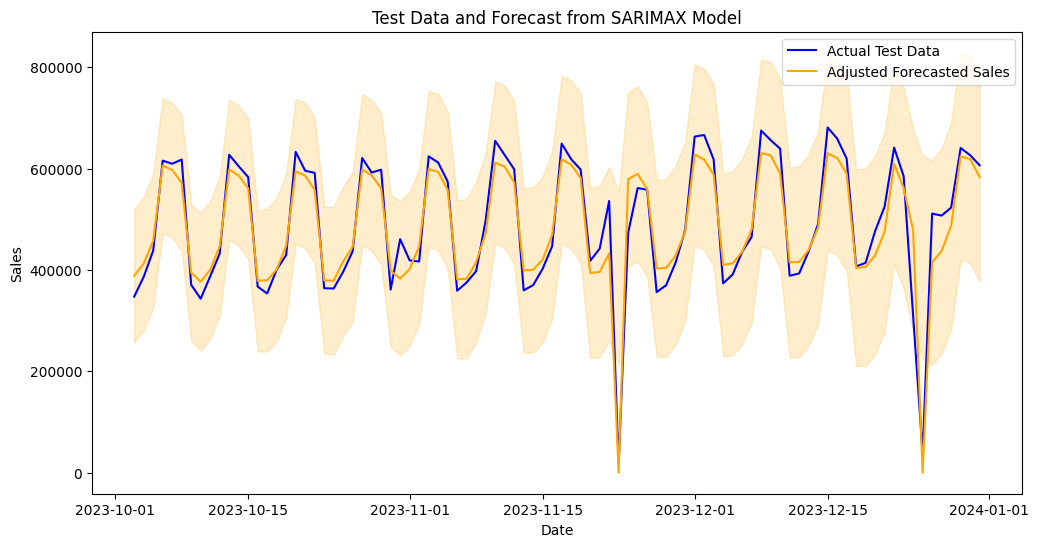

In [175]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['NET_SALES_FINAL_USD_AMOUNT'], label = 'Actual Test Data', color = 'blue')
plt.plot(adjusted_predictions_df['BUSINESS_DATE'], adjusted_predictions_df['Adjusted_Predicted_Sales'],
         label='Adjusted Forecasted Sales', color = 'orange')
plt.fill_between(test.index, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1],
                 color = 'orange', alpha = 0.2)
plt.title('Test Data and Forecast from SARIMAX Model')
plt.xlabel('Date')
plt.ylabel('Sales')
#plt.axvline(x = test[test.index == '2023-11-23'].index, color = 'red')
#plt.axvline(x = test[test.index == '2023-12-25'].index, color = 'red')
plt.legend()
plt.show()

In [176]:
# Define dates to exclude
exclude_dates = pd.to_datetime(['2023-11-23', '2023-12-25'])

# Filter out the excluded dates
mask = ~test.index.isin(exclude_dates)

actual = test['NET_SALES_FINAL_USD_AMOUNT']
actual_excl = test.loc[mask, 'NET_SALES_FINAL_USD_AMOUNT']

mape = np.mean(np.abs((actual - adjusted_predictions_df['Adjusted_Predicted_Sales']) / actual)) * 100
print(f"MAPE: {mape:.2f}%")

smape = np.mean(np.abs((actual - adjusted_predictions_df['Adjusted_Predicted_Sales']) / (actual + adjusted_predictions_df['Adjusted_Predicted_Sales'])) * 200)
print(f"sMAPE: {smape:.2f}%")

mape_excl = np.mean(np.abs((actual_excl - adjusted_predictions_df['Adjusted_Predicted_Sales'][mask]) / actual_excl)) * 100
print(f"MAPE excluding the 2 spikes: {mape_excl:.2f}%")

MAPE: 8.35%
sMAPE: 10.48%
MAPE excluding the 2 spikes: 6.26%


In [177]:
cluster_forecasts.append(adjusted_predictions_df['Adjusted_Predicted_Sales'])

##<font color = magenta> Disaggregation: Simple Recent Proportions

In [178]:
disaggregated_forecasts = disaggregate(c_number = 1,
                                       forecast_series = adjusted_predictions_df['Adjusted_Predicted_Sales'],
                                       period = '1Y')
pd.concat([disaggregated_forecasts.head(), disaggregated_forecasts.tail()])

38           61            250          1348          1373  \
2023-10-03  6148.837172  5432.753884   6306.826735  3582.559313   7654.060312   
2023-10-04  6527.466047  5767.288275   6695.184184  3803.163692   8125.376785   
2023-10-05  7235.669044  6393.015136   7421.583903  4215.791181   9006.946471   
2023-10-06  9590.676672  8473.762516   9837.101610  5587.913140  11938.455294   
2023-10-07  9451.240298  8350.564669   9694.082527  5506.671912  11764.885172   
2023-12-27  6921.911274  6115.797071   7099.764372  4032.983311   8616.381421   
2023-12-28  7713.270563  6814.995981   7911.457019  4494.060993   9601.463894   
2023-12-29  9876.428188  8726.235889  10130.195288  5754.403441  12294.158213   
2023-12-30  9794.052512  8653.453547  10045.703034  5706.408067  12191.617136   
2023-12-31  9228.260246  8153.552501   9465.373177  5376.754785  11487.320046   

                   1400         1409         1420         1423         1454  \
2023-10-03  4147.905915  3832.576082  2825.597268  5655.215145  4923.337954   
2023-10-04  4403.322819  4068.575821  2999.589958  6003.448102  5226.503880   
2023-10-05  4881.065084  4509.999426  3325.033029  6654.797325  5793.557876   
2023-10-06  6469.715067  5977.877929  4407.238157  8820.747477  7679.198708   
2023-10-07  6375.653549  5890.967104  4343.162459  8692.504904  7567.552818   
2023-12-27  4669.409177  4314.433908  3180.850792  6366.227691  5542.333865   
2023-12-28  5203.247329  4807.688909  3544.506973  7094.057508  6175.970619   
2023-12-29  6662.478409  6155.987122  4538.550580  9083.559168  7907.998275   
2023-12-30  6606.909113  6104.642285  4500.696189  9007.796523  7842.040553   
2023-12-31  6225.234819  5751.983425  4240.695633  8487.425451  7389.013995   

            ...         2346         2355          2368         2377  \
2023-10-03  ...  3943.477890  5969.365394   9512.470637  3968.206989   
2023-10-04  ...  4186.306665  6336.942879  10098.223026  4212.558515   
2023-10-05  ...  4640.503578  7024.474903  11193.838347  4669.603645   
2023-10-06  ...  6150.857527  9310.744752  14837.119228  6189.428852   
2023-10-07  ...  6061.431796  9175.378236  14621.406179  6099.442342   
2023-12-27  ...  4439.279054  6719.875070  10708.443874  4467.117265   
2023-12-28  ...  4946.807189  7488.136226  11932.704948  4977.828051   
2023-12-29  ...  6334.120599  9588.155775  15279.187025  6373.841145   
2023-12-30  ...  6281.290015  9508.184474  15151.748914  6320.679267   
2023-12-31  ...  5918.426399  8958.906509  14276.448078  5955.540174   

                   2416         2429         2439         2443         2447  \
2023-10-03  2936.848567  2453.755532  2751.045031  6159.647175  3144.848332   
2023-10-04  3117.691813  2604.851206  2920.446994  6538.941702  3338.499645   
2023-10-05  3455.948446  2887.466759  3237.303382  7248.389760  3700.713012   
2023-10-06  4580.762876  3827.256322  4290.954967  9607.537624  4905.191453   
2023-10-07  4514.164346  3771.612829  4228.569880  9467.856113  4833.876139   
2023-12-27  3306.089370  2762.258555  3096.925335  6934.080386  3540.240296   
2023-12-28  3684.063665  3078.058466  3450.986595  7726.830929  3944.984294   
2023-12-29  4717.245418  3941.288348  4418.802764  9893.791507  5051.340253   
2023-12-30  4677.900599  3908.415503  4381.947147  9811.271010  5009.208872   
2023-12-31  4407.663128  3682.630389  4128.806600  9244.484049  4719.832065   

                   2467  
2023-10-03  5253.763544  
2023-10-04  5577.276190  
2023-10-05  6182.387528  
2023-10-06  8194.581521  
2023-10-07  8075.442614  
2023-12-27  5914.302833  
2023-12-28  6590.465572  
2023-12-29  8438.736774  
2023-12-30  8368.352357  
2023-12-31  7884.921311  

[10 rows x 87 columns]

In [179]:
# Select a random store_key from the list of store keys
random_store_key = random.choice(list(disaggregated_forecasts.columns))
print(f"Randomly selected store_key: {random_store_key}")

Randomly selected store_key: 2299


In [180]:
# Extract actual sales for the selected store
actual_sales = df[df['STORE_KEY'] == random_store_key].set_index('BUSINESS_DATE')['NET_SALES_FINAL_USD_AMOUNT'].sort_index()[-90:]

# Extract forecasted sales for the selected store
forecasted_sales = disaggregated_forecasts[random_store_key]

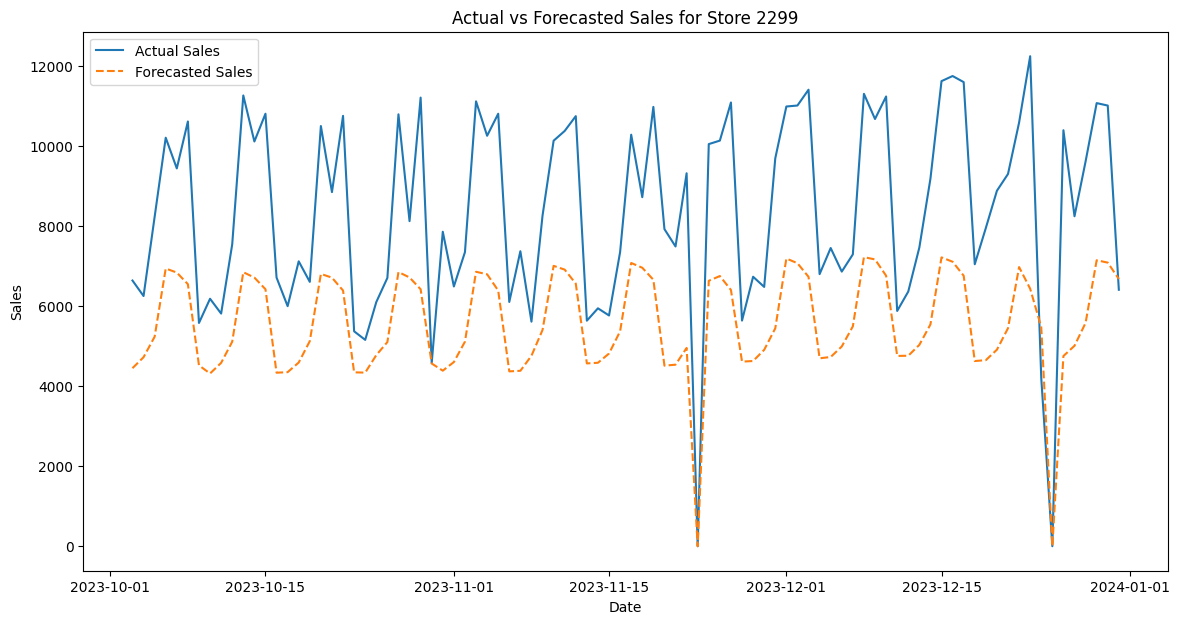

In [181]:
# Combine actual and forecasted sales into a single DataFrame
combined_sales = pd.concat([actual_sales, forecasted_sales], axis=1)
combined_sales.columns = ['Actual Sales', 'Forecasted Sales']

# Plot the actual and forecasted sales
plt.figure(figsize = (14, 7))
plt.plot(combined_sales['Actual Sales'], label = 'Actual Sales')
plt.plot(combined_sales['Forecasted Sales'], label = 'Forecasted Sales', linestyle = '--')
plt.title(f'Actual vs Forecasted Sales for Store {random_store_key}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#<font color = blue> Cluster 2

In [182]:
cluster_2_data = cluster_data(2)
pd.concat([cluster_2_data.head(), cluster_2_data.tail()])

NET_SALES_FINAL_USD_AMOUNT  percentage_ubereats  \
BUSINESS_DATE                                                    
2019-04-23                      159212.75                14.04   
2019-04-24                      163087.21                14.04   
2019-04-25                      193841.20                14.04   
2019-04-26                      267356.83                14.04   
2019-04-27                      236732.52                14.04   
2023-12-27                      307663.87               100.00   
2023-12-28                      323123.28               100.00   
2023-12-29                      385519.68               100.00   
2023-12-30                      377731.90               100.00   
2023-12-31                      327288.11               100.00   

               sum_ubereats_age  day_of_year  doordash_age_days  \
BUSINESS_DATE                                                     
2019-04-23               395928          113              79606   
2019-04-24               395928          114              79606   
2019-04-25               395928          115              79606   
2019-04-26               395928          116              79606   
2019-04-27               395928          117              79606   
2023-12-27               395928          361              79606   
2023-12-28               395928          362              79606   
2023-12-29               395928          363              79606   
2023-12-30               395928          364              79606   
2023-12-31               395928          365              79606   

               ubereats_age_days  py_net_sales  PLATFORM_DD  PLATFORM_Inhouse  \
BUSINESS_DATE                                                                   
2019-04-23                 91219          0.00            0                 0   
2019-04-24                 91219          0.00            0                 0   
2019-04-25                 91219          0.00            0                 0   
2019-04-26                 91219          0.00            0                 0   
2019-04-27                 91219          0.00            0                 0   
2023-12-27                 91219     269394.83            0                 0   
2023-12-28                 91219     317112.32            0                 0   
2023-12-29                 91219     363267.79            0                 0   
2023-12-30                 91219     324558.92            0                 0   
2023-12-31                 91219     284892.95            0                 0   

               PLATFORM_UE  FREQUENCY_Weekday  PromotionCash  PromotionKind  \
BUSINESS_DATE                                                                 
2019-04-23               0                  0              0              0   
2019-04-24               0                  0              0              0   
2019-04-25               0                  0              0              0   
2019-04-26               0                  0              0              0   
2019-04-27               0                  0              0              0   
2023-12-27               0                  0              0              0   
2023-12-28               0                  0              0              0   
2023-12-29               0                  0              0              0   
2023-12-30               0                  0              0              0   
2023-12-31               0                  0              0              0   

               PROMOTION_ITEM_DeliveryFee  PROMOTION_COVERAGE_Regional  
BUSINESS_DATE                                                           
2019-04-23                              0                            0  
2019-04-24                              0                            0  
2019-04-25                              0                            0  
2019-04-26                              0                            0  
2019-04-27                              0                

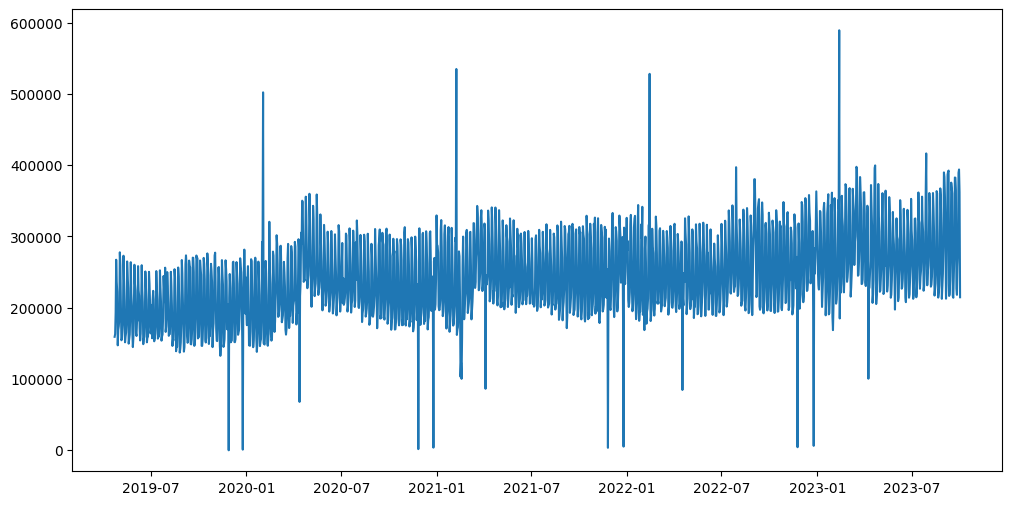

In [183]:
# Split data into train and test sets
train = cluster_2_data.iloc[:-90]  # Assuming the last 90 days are for testing
test = cluster_2_data.iloc[-90:]

plt.figure(figsize = (12, 6))
plt.plot(train['NET_SALES_FINAL_USD_AMOUNT'])

In [184]:
# Normalize all but indicator features
columns = ['percentage_ubereats', 'sum_ubereats_age',
       'day_of_year', 'doordash_age_days', 'ubereats_age_days', 'py_net_sales']
scaler = StandardScaler()
train[columns] = scaler.fit_transform(train[columns])
test[columns] = scaler.transform(test[columns])

##<font color = magenta> ACF-PACF Analysis

<Figure size 1000x500 with 0 Axes>

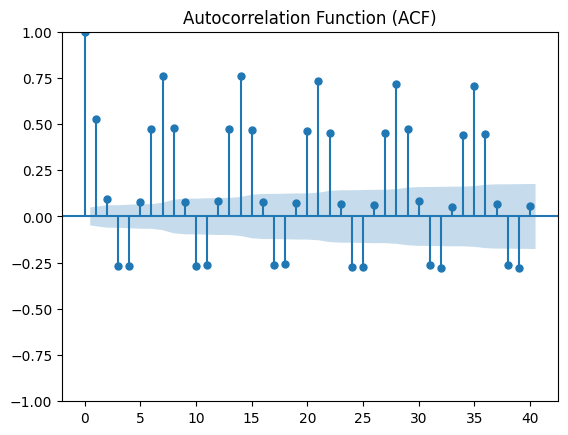

<Figure size 1000x500 with 0 Axes>

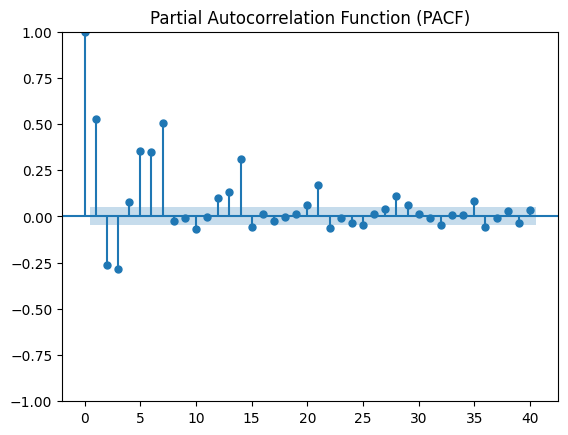

In [185]:
# Extract the sales time series
sales = train['NET_SALES_FINAL_USD_AMOUNT']

# Plot ACF
plt.figure(figsize = (10, 5))
plot_acf(sales, lags = 40, alpha = 0.05)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize = (10, 5))
plot_pacf(sales, lags = 40, alpha = 0.05, method = 'ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

<Figure size 1000x500 with 0 Axes>

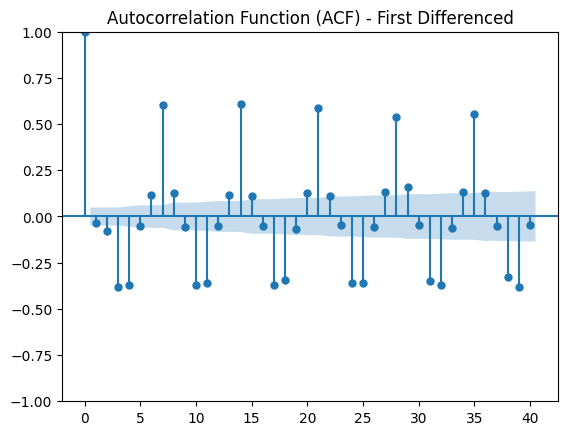

<Figure size 1000x500 with 0 Axes>

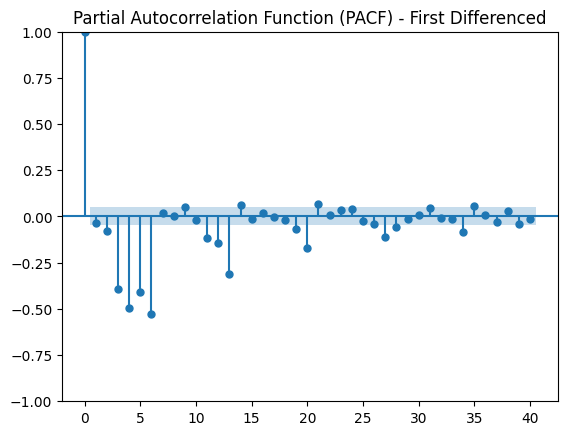

In [186]:
# Compute the first difference
sales_diff = sales.diff().dropna()

# Plot ACF for first differenced data
plt.figure(figsize = (10, 5))
plot_acf(sales_diff, lags = 40, alpha = 0.05)
plt.title('Autocorrelation Function (ACF) - First Differenced')
plt.show()

# Plot PACF for first differenced data
plt.figure(figsize = (10, 5))
plot_pacf(sales_diff, lags = 40, alpha = 0.05, method = 'ywm')
plt.title('Partial Autocorrelation Function (PACF) - First Differenced')
plt.show()

##<font color = magenta> SARIMAX

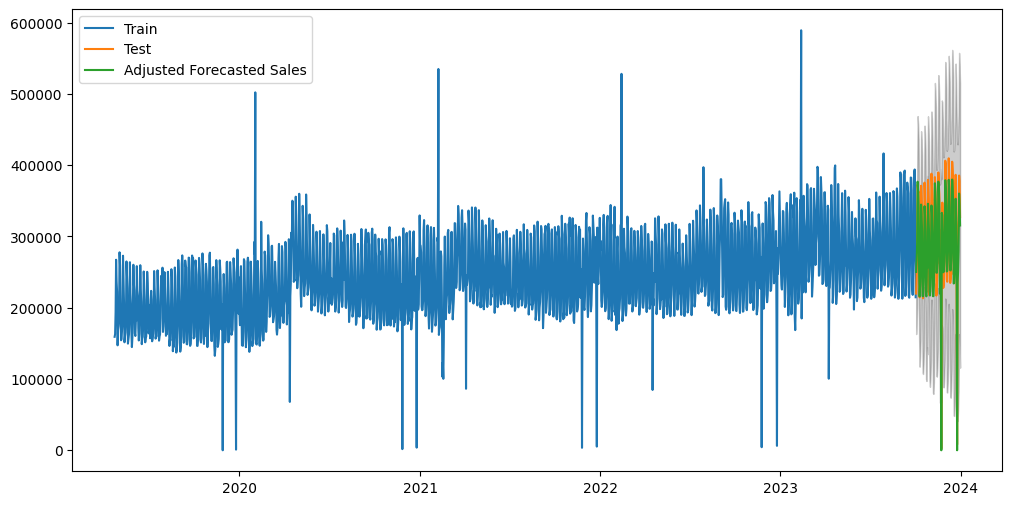

In [187]:
exog_vars = ['percentage_ubereats', 'sum_ubereats_age', 'day_of_year',
             'doordash_age_days', 'ubereats_age_days', 'py_net_sales', 'PLATFORM_DD',
       'PLATFORM_Inhouse', 'PLATFORM_UE', 'FREQUENCY_Weekday', 'PromotionCash',
       'PromotionKind', 'PROMOTION_ITEM_DeliveryFee',
       'PROMOTION_COVERAGE_Regional']


# Fit the SARIMAX model
model = SARIMAX(train['NET_SALES_FINAL_USD_AMOUNT'],
                exog = train[exog_vars],
                order = (0, 1, 1), seasonal_order = (0, 1, 1, 7))
model_fit = model.fit(disp = False)

# Forecast
forecast = model_fit.get_forecast(steps = len(test),
                                  exog = test[exog_vars])

forecast_conf = forecast.conf_int()
forecast_series = forecast.predicted_mean

# Create a DataFrame for the forecasts
forecast_df = pd.DataFrame({
    'BUSINESS_DATE': test.index,
    'Predicted_Sales': forecast_series
})

# Initialize the adjusted predictions with the original forecasts
adjusted_forecast = forecast_series.copy()

# Adjust the forecasts based on special dates
for i in range(len(forecast_df)):
    date = forecast_df['BUSINESS_DATE'].iloc[i]

    if date in downspike_dates:
        adjusted_forecast[i] = 0 # Set downspikes sales to zero
    elif date in upspike_dates:
        if i > 0:
            adjusted_forecast[i] = adjusted_forecast[i-1] + forecast_series[i]  # Add the forecasted value to the previous value for upspike dates
    else:
        adjusted_forecast[i] = forecast_series[i]  # Keep the original forecast for other dates

# Create a DataFrame for the adjusted predictions
adjusted_predictions_df = pd.DataFrame({
    'BUSINESS_DATE': forecast_df['BUSINESS_DATE'],
    'Adjusted_Predicted_Sales': adjusted_forecast
})

# Plot the results
plt.figure(figsize = (12, 6))
plt.plot(train['NET_SALES_FINAL_USD_AMOUNT'], label = 'Train')
plt.plot(test['NET_SALES_FINAL_USD_AMOUNT'], label = 'Test')
plt.plot(adjusted_predictions_df['BUSINESS_DATE'], adjusted_predictions_df['Adjusted_Predicted_Sales'], label='Adjusted Forecasted Sales')
#plt.plot(forecast_series, label = 'Forecast')
plt.fill_between(forecast_conf.index, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1],
                 color = 'k', alpha = 0.2)
plt.legend()
plt.show()

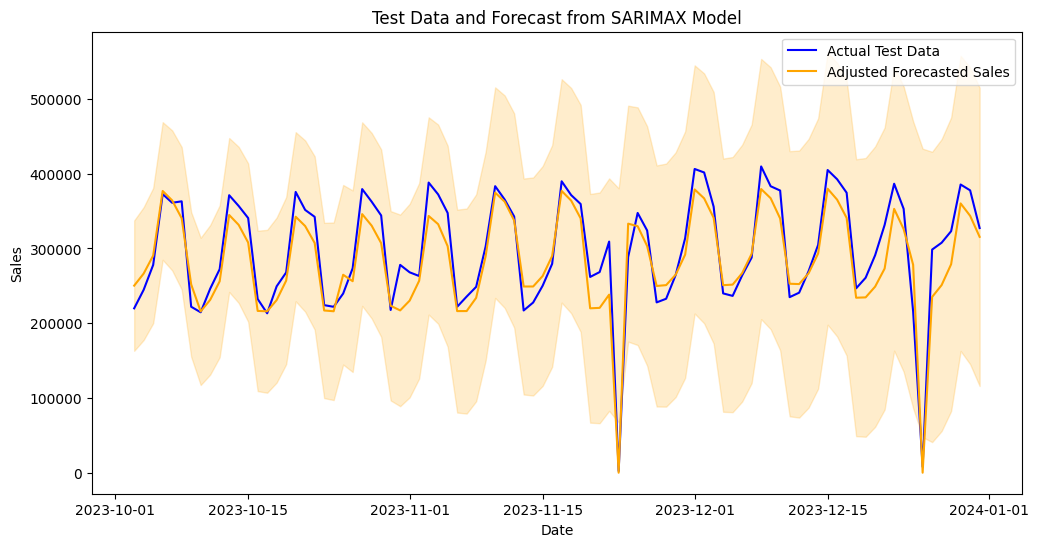

In [188]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['NET_SALES_FINAL_USD_AMOUNT'], label = 'Actual Test Data', color = 'blue')
plt.plot(adjusted_predictions_df['BUSINESS_DATE'], adjusted_predictions_df['Adjusted_Predicted_Sales'],
         label='Adjusted Forecasted Sales', color = 'orange')
plt.fill_between(test.index, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1],
                 color = 'orange', alpha = 0.2)
plt.title('Test Data and Forecast from SARIMAX Model')
plt.xlabel('Date')
plt.ylabel('Sales')
#plt.axvline(x = test[test.index == '2023-11-23'].index, color = 'red')
#plt.axvline(x = test[test.index == '2023-12-25'].index, color = 'red')
plt.legend()
plt.show()

In [189]:
# Define dates to exclude
exclude_dates = pd.to_datetime(['2023-11-23', '2023-12-25'])

# Filter out the excluded dates
mask = ~test.index.isin(exclude_dates)

actual = test['NET_SALES_FINAL_USD_AMOUNT']
actual_excl = test.loc[mask, 'NET_SALES_FINAL_USD_AMOUNT']

mape = np.mean(np.abs((actual - adjusted_predictions_df['Adjusted_Predicted_Sales']) / actual)) * 100
print(f"MAPE: {mape:.2f}%")

smape = np.mean(np.abs((actual - adjusted_predictions_df['Adjusted_Predicted_Sales']) / (actual + adjusted_predictions_df['Adjusted_Predicted_Sales'])) * 200)
print(f"sMAPE: {smape:.2f}%")

mape_excl = np.mean(np.abs((actual_excl - adjusted_predictions_df['Adjusted_Predicted_Sales'][mask]) / actual_excl)) * 100
print(f"MAPE excluding the 2 spikes: {mape_excl:.2f}%")

MAPE: 9.94%
sMAPE: 12.39%
MAPE excluding the 2 spikes: 7.89%


In [190]:
cluster_forecasts.append(adjusted_predictions_df['Adjusted_Predicted_Sales'])

##<font color = magenta> Disaggregation: Simple Recent Proportions

In [191]:
disaggregated_forecasts = disaggregate(c_number = 2,
                                       forecast_series = adjusted_predictions_df['Adjusted_Predicted_Sales'],
                                       period = '1Y')
pd.concat([disaggregated_forecasts.head(), disaggregated_forecasts.tail()])

825          828          839          850          854   \
2023-10-03  2451.350609  6258.894257  5056.903012  4993.267568  6224.109192   
2023-10-04  2609.815929  6663.494757  5383.801887  5316.052788  6626.461044   
2023-10-05  2845.151861  7264.364624  5869.277519  5795.419254  7223.991456   
2023-10-06  3691.800397  9426.064234  7615.832872  7519.996169  9373.676985   
2023-10-07  3568.269086  9110.658756  7360.999535  7268.369624  9060.024437   
2023-12-27  2458.604352  6277.414826  5071.866793  5008.043047  6242.526829   
2023-12-28  2731.937852  6975.301725  5635.727792  5564.808488  6936.535082   
2023-12-29  3528.787589  9009.852893  7279.552964  7187.947967  8959.778823   
2023-12-30  3366.140002  8594.574048  6944.026471  6856.643698  8546.807973   
2023-12-31  3090.349821  7890.414644  6375.097573  6294.874131  7846.562077   

                   862          874          875          884          887   \
2023-10-03  3540.526011  3598.147632  2505.737615  5355.793408  6042.749867   
2023-10-04  3769.400080  3830.746598  2667.718733  5702.013779  6433.377910   
2023-10-05  4109.299639  4176.177980  2908.275957  6216.183654  7013.497363   
2023-10-06  5332.128046  5418.907768  3773.708700  8065.969901  9100.544930   
2023-10-07  5153.709743  5237.585728  3647.436656  7796.074532  8796.031652   
2023-12-27  3551.002711  3608.794839  2513.152293  5371.641630  6060.630847   
2023-12-28  3945.782783  4009.999907  2792.550120  5968.829871  6734.416950   
2023-12-29  5096.685967  5179.633898  3607.079201  7709.814027  8698.707014   
2023-12-30  4861.771381  4940.896106  3440.823026  7354.456098  8297.769391   
2023-12-31  4463.443085  4536.085067  3158.914012  6751.900417  7617.927399   

            ...         1264          1265         1275          1291  \
2023-10-03  ...  1819.099869   7157.714420  3336.445960   7118.309093   
2023-10-04  ...  1936.693918   7620.418328  3552.127460   7578.465680   
2023-10-05  ...  2111.332161   8307.577231  3872.434811   8261.841571   
2023-10-06  ...  2739.613662  10779.711738  5024.777962  10720.366249   
2023-10-07  ...  2647.943466  10419.011870  4856.643898  10361.652140   
2023-12-27  ...  1824.482731   7178.894670  3346.318770   7139.372739   
2023-12-28  ...  2027.318235   7977.002917  3718.343258   7933.087165   
2023-12-29  ...  2618.645011  10303.729593  4802.907039  10247.004526   
2023-12-30  ...  2497.947383   9828.813857  4581.533204   9774.703341   
2023-12-31  ...  2293.288824   9023.532331  4206.165016   8973.855127   

                   1306         1322         1336          1399         1752  \
2023-10-03  4740.724404  3473.820704  4422.501138   8042.841426  5144.442667   
2023-10-04  5047.184201  3698.382669  4708.389683   8562.763561  5477.000462   
2023-10-05  5502.305877  4031.878348  5132.961111   9334.896922  5970.880124   
2023-10-06  7139.659325  5231.668048  6660.406470  12112.736978  7747.669961   
2023-10-07  6900.759228  5056.611235  6437.542650  11707.432760  7488.425224   
2023-12-27  4754.752587  3484.100018  4435.587673   8066.640838  5159.665484   
2023-12-28  5283.358650  3871.442232  4928.710816   8963.443601  5733.287436   
2023-12-29  6824.405036  5000.661817  6366.313768  11577.894612  7405.568739   
2023-12-30  6509.857055  4770.173141  6072.879962  11044.250527  7064.233972   
2023-12-31  5976.499958  4379.349552  5575.324701  10139.387433  6485.456391   

                   1761  
2023-10-03  4115.742915  
2023-10-04  4381.801355  
2023-10-05  4776.923209  
2023-10-06  6198.420279  
2023-10-07  5991.014977  
2023-12-27  4127.921728  
2023-12-28  4586.840339  
2023-12-29  5924.726748  
2023-12-30  5651.646409  
2023-12-31  5188.603104  

[10 rows x 57 columns]

In [192]:
# Select a random store_key from the list of store keys
random_store_key = random.choice(list(disaggregated_forecasts.columns))
print(f"Randomly selected store_key: {random_store_key}")

Randomly selected store_key: 1130


In [193]:
# Extract actual sales for the selected store
actual_sales = df[df['STORE_KEY'] == random_store_key].set_index('BUSINESS_DATE')['NET_SALES_FINAL_USD_AMOUNT'].sort_index()[-90:]

# Extract forecasted sales for the selected store
forecasted_sales = disaggregated_forecasts[random_store_key]

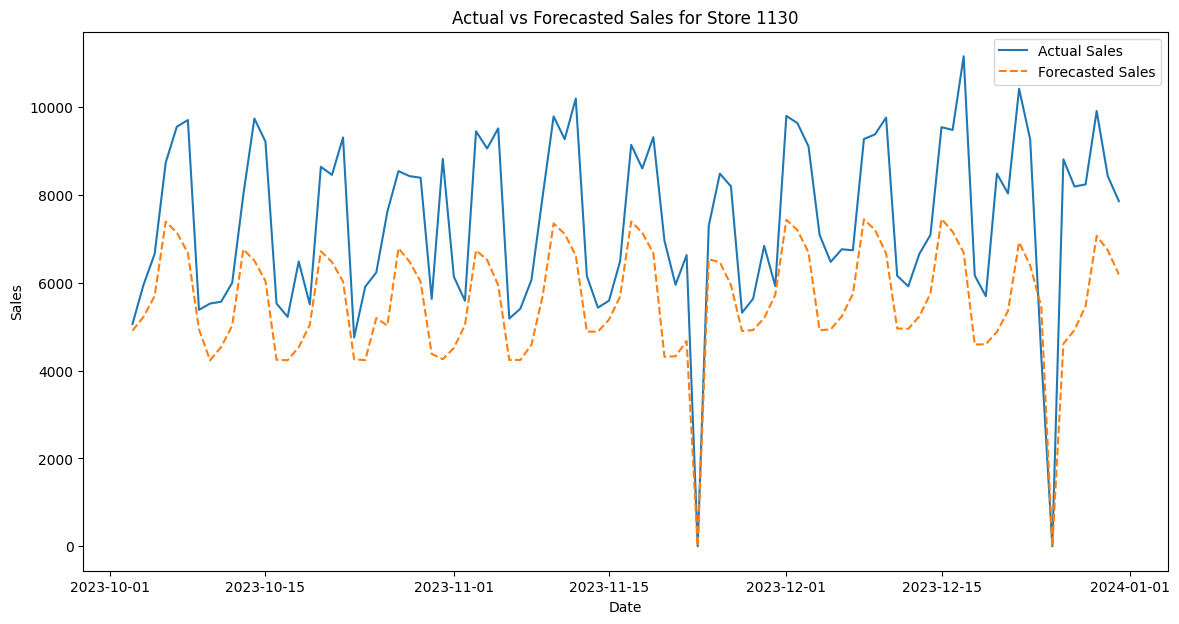

In [194]:
# Combine actual and forecasted sales into a single DataFrame
combined_sales = pd.concat([actual_sales, forecasted_sales], axis=1)
combined_sales.columns = ['Actual Sales', 'Forecasted Sales']

# Plot the actual and forecasted sales
plt.figure(figsize = (14, 7))
plt.plot(combined_sales['Actual Sales'], label = 'Actual Sales')
plt.plot(combined_sales['Forecasted Sales'], label = 'Forecasted Sales', linestyle = '--')
plt.title(f'Actual vs Forecasted Sales for Store {random_store_key}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#<font color = blue> Cluster 3

In [195]:
cluster_3_data = cluster_data(3)
pd.concat([cluster_3_data.head(), cluster_3_data.tail()])

NET_SALES_FINAL_USD_AMOUNT  percentage_ubereats  \
BUSINESS_DATE                                                    
2019-04-23                      264454.02                15.38   
2019-04-24                      268968.90                15.38   
2019-04-25                      317887.02                15.38   
2019-04-26                      450914.35                15.38   
2019-04-27                      410155.78                15.38   
2023-12-27                      534649.26               100.00   
2023-12-28                      554441.83               100.00   
2023-12-29                      679049.01               100.00   
2023-12-30                      714163.93               100.00   
2023-12-31                      623184.78               100.00   

               sum_ubereats_age  day_of_year  doordash_age_days  \
BUSINESS_DATE                                                     
2019-04-23               338082          113              89511   
2019-04-24               338082          114              89511   
2019-04-25               338082          115              89511   
2019-04-26               338082          116              89511   
2019-04-27               338082          117              89511   
2023-12-27               339913          361              90906   
2023-12-28               339913          362              90906   
2023-12-29               339913          363              90906   
2023-12-30               339913          364              90906   
2023-12-31               339913          365              90906   

               ubereats_age_days  py_net_sales  PLATFORM_DD  PLATFORM_Inhouse  \
BUSINESS_DATE                                                                   
2019-04-23                 88990          0.00            0                 0   
2019-04-24                 88990          0.00            0                 0   
2019-04-25                 88990          0.00            0                 0   
2019-04-26                 88990          0.00            0                 0   
2019-04-27                 88990          0.00            0                 0   
2023-12-27                 89724     456605.43            0                 0   
2023-12-28                 89724     551874.89            0                 0   
2023-12-29                 89724     635341.16            0                 0   
2023-12-30                 89724     614524.50            0                 0   
2023-12-31                 89724     581262.28            0                 0   

               PLATFORM_UE  FREQUENCY_Weekday  PromotionCash  PromotionKind  \
BUSINESS_DATE                                                                 
2019-04-23               0                  0              0              0   
2019-04-24               0                  0              0              0   
2019-04-25               0                  0              0              0   
2019-04-26               0                  0              0              0   
2019-04-27               0                  0              0              0   
2023-12-27               0                  0              0              0   
2023-12-28               0                  0              0              0   
2023-12-29               0                  0              0              0   
2023-12-30               0                  0              0              0   
2023-12-31               0                  0              0              0   

               PROMOTION_ITEM_DeliveryFee  PROMOTION_COVERAGE_Regional  
BUSINESS_DATE                                                           
2019-04-23                              0                            0  
2019-04-24                              0                            0  
2019-04-25                              0                            0  
2019-04-26                              0                            0  
2019-04-27                              0                

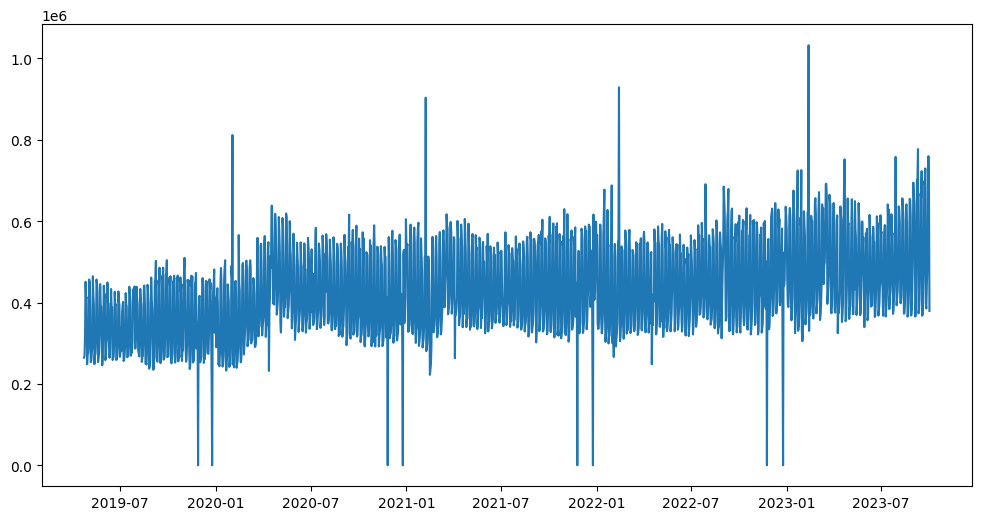

In [196]:
# Split data into train and test sets
train = cluster_3_data.iloc[:-90]  # Assuming the last 90 days are for testing
test = cluster_3_data.iloc[-90:]

plt.figure(figsize = (12, 6))
plt.plot(train['NET_SALES_FINAL_USD_AMOUNT'])

In [197]:
# Normalize all but indicator features
columns = ['percentage_ubereats', 'sum_ubereats_age',
       'day_of_year', 'doordash_age_days', 'ubereats_age_days', 'py_net_sales']
scaler = StandardScaler()
train[columns] = scaler.fit_transform(train[columns])
test[columns] = scaler.transform(test[columns])

##<font color = magenta> ACF-PACF Analysis

<Figure size 1000x500 with 0 Axes>

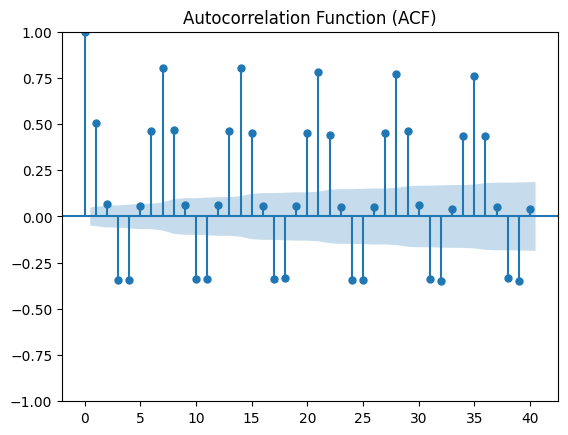

<Figure size 1000x500 with 0 Axes>

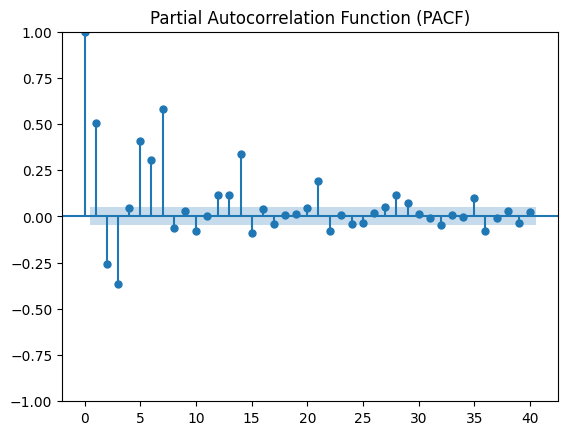

In [198]:
# Extract the sales time series
sales = train['NET_SALES_FINAL_USD_AMOUNT']

# Plot ACF
plt.figure(figsize = (10, 5))
plot_acf(sales, lags = 40, alpha = 0.05)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize = (10, 5))
plot_pacf(sales, lags = 40, alpha = 0.05, method = 'ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

<Figure size 1000x500 with 0 Axes>

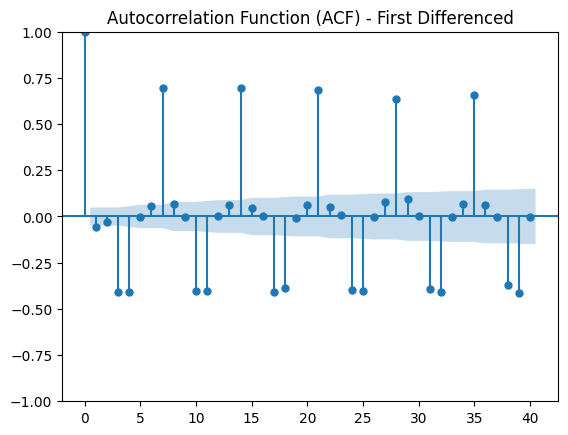

<Figure size 1000x500 with 0 Axes>

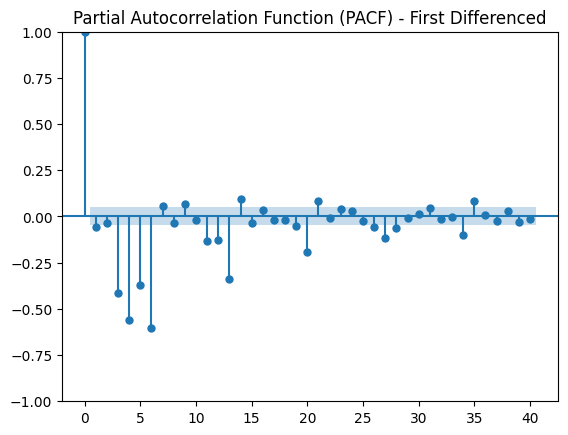

In [199]:
# Compute the first difference
sales_diff = sales.diff().dropna()

# Plot ACF for first differenced data
plt.figure(figsize = (10, 5))
plot_acf(sales_diff, lags = 40, alpha = 0.05)
plt.title('Autocorrelation Function (ACF) - First Differenced')
plt.show()

# Plot PACF for first differenced data
plt.figure(figsize = (10, 5))
plot_pacf(sales_diff, lags = 40, alpha = 0.05, method = 'ywm')
plt.title('Partial Autocorrelation Function (PACF) - First Differenced')
plt.show()

##<font color = magenta> SARIMAX

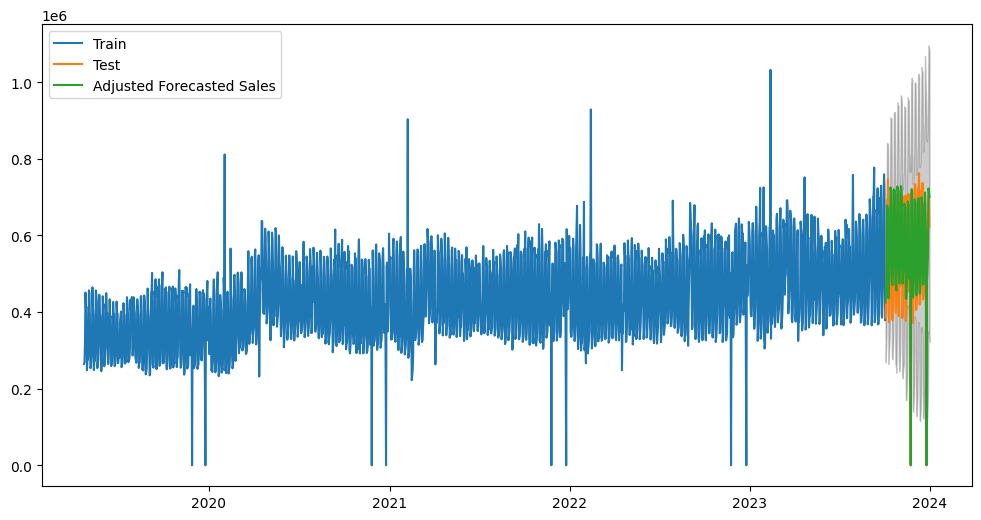

In [200]:
exog_vars = ['percentage_ubereats', 'sum_ubereats_age', 'day_of_year',
             'doordash_age_days', 'ubereats_age_days', 'py_net_sales', 'PLATFORM_DD',
       'PLATFORM_Inhouse', 'PLATFORM_UE', 'FREQUENCY_Weekday', 'PromotionCash',
       'PromotionKind', 'PROMOTION_ITEM_DeliveryFee',
       'PROMOTION_COVERAGE_Regional']


# Fit the SARIMAX model
model = SARIMAX(train['NET_SALES_FINAL_USD_AMOUNT'],
                exog = train[exog_vars],
                order = (0, 1, 1), seasonal_order = (0, 1, 1, 7))
model_fit = model.fit(disp = False)

# Forecast
forecast = model_fit.get_forecast(steps = len(test),
                                  exog = test[exog_vars])

forecast_conf = forecast.conf_int()
forecast_series = forecast.predicted_mean

# Create a DataFrame for the forecasts
forecast_df = pd.DataFrame({
    'BUSINESS_DATE': test.index,
    'Predicted_Sales': forecast_series
})

# Initialize the adjusted predictions with the original forecasts
adjusted_forecast = forecast_series.copy()

# Adjust the forecasts based on special dates
for i in range(len(forecast_df)):
    date = forecast_df['BUSINESS_DATE'].iloc[i]

    if date in downspike_dates:
        adjusted_forecast[i] = 0 # Set downspikes sales to zero
    elif date in upspike_dates:
        if i > 0:
            adjusted_forecast[i] = adjusted_forecast[i-1] + forecast_series[i]  # Add the forecasted value to the previous value for upspike dates
    else:
        adjusted_forecast[i] = forecast_series[i]  # Keep the original forecast for other dates

# Create a DataFrame for the adjusted predictions
adjusted_predictions_df = pd.DataFrame({
    'BUSINESS_DATE': forecast_df['BUSINESS_DATE'],
    'Adjusted_Predicted_Sales': adjusted_forecast
})

# Plot the results
plt.figure(figsize = (12, 6))
plt.plot(train['NET_SALES_FINAL_USD_AMOUNT'], label = 'Train')
plt.plot(test['NET_SALES_FINAL_USD_AMOUNT'], label = 'Test')
plt.plot(adjusted_predictions_df['BUSINESS_DATE'], adjusted_predictions_df['Adjusted_Predicted_Sales'], label='Adjusted Forecasted Sales')
#plt.plot(forecast_series, label = 'Forecast')
plt.fill_between(forecast_conf.index, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1],
                 color = 'k', alpha = 0.2)
plt.legend()
plt.show()

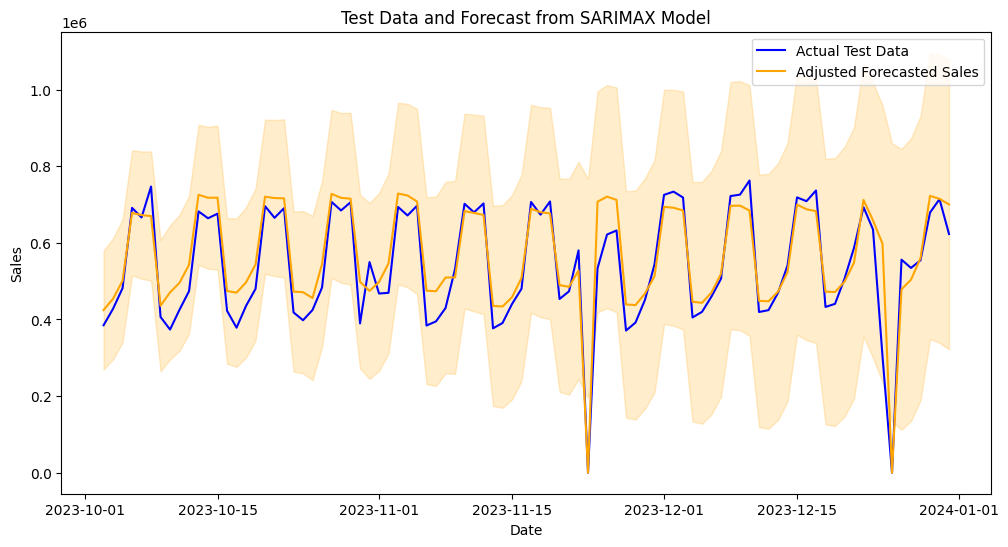

In [201]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['NET_SALES_FINAL_USD_AMOUNT'], label = 'Actual Test Data', color = 'blue')
plt.plot(adjusted_predictions_df['BUSINESS_DATE'], adjusted_predictions_df['Adjusted_Predicted_Sales'],
         label='Adjusted Forecasted Sales', color = 'orange')
plt.fill_between(test.index, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1],
                 color = 'orange', alpha = 0.2)
plt.title('Test Data and Forecast from SARIMAX Model')
plt.xlabel('Date')
plt.ylabel('Sales')
#plt.axvline(x = test[test.index == '2023-11-23'].index, color = 'red')
#plt.axvline(x = test[test.index == '2023-12-25'].index, color = 'red')
plt.legend()
plt.show()

In [202]:
# Define dates to exclude
exclude_dates = pd.to_datetime(['2023-11-23', '2023-12-25'])

# Filter out the excluded dates
mask = ~test.index.isin(exclude_dates)

actual = test['NET_SALES_FINAL_USD_AMOUNT']
actual_excl = test.loc[mask, 'NET_SALES_FINAL_USD_AMOUNT']

mape = np.mean(np.abs((actual - adjusted_predictions_df['Adjusted_Predicted_Sales']) / actual)) * 100
print(f"MAPE: {mape:.2f}%")

smape = np.mean(np.abs((actual - adjusted_predictions_df['Adjusted_Predicted_Sales']) / (actual + adjusted_predictions_df['Adjusted_Predicted_Sales'])) * 200)
print(f"sMAPE: {smape:.2f}%")

mape_excl = np.mean(np.abs((actual_excl - adjusted_predictions_df['Adjusted_Predicted_Sales'][mask]) / actual_excl)) * 100
print(f"MAPE excluding the 2 spikes: {mape_excl:.2f}%")

MAPE: 9.36%
sMAPE: 8.60%
MAPE excluding the 2 spikes: 9.36%


In [203]:
cluster_forecasts.append(adjusted_predictions_df['Adjusted_Predicted_Sales'])

##<font color = magenta> Disaggregation: Simple Recent Proportions

In [204]:
disaggregated_forecasts = disaggregate(c_number = 3,
                                       forecast_series = adjusted_predictions_df['Adjusted_Predicted_Sales'],
                                       period = '1Y')
pd.concat([disaggregated_forecasts.head(), disaggregated_forecasts.tail()])

885          895          901           917          960   \
2023-10-03  12319.460905  4320.235843  5543.234810   6326.785660  5420.766280   
2023-10-04  13173.845142  4619.854587  5927.671474   6765.563459  5796.709456   
2023-10-05  14537.123687  5097.934340  6541.088988   7465.689156  6396.574533   
2023-10-06  19678.979185  6901.099965  8854.705842  10106.341850  8659.075881   
2023-10-07  19512.221754  6842.620829  8779.672073  10020.701860  8585.699857   
2023-12-27  14618.591842  5126.503906  6577.746202   7507.527964  6432.421867   
2023-12-28  16254.304487  5700.121895  7313.747505   8347.564991  7152.162448   
2023-12-29  20969.130647  7353.535232  9435.219272  10768.912383  9226.763834   
2023-12-30  20743.201128  7274.305402  9333.560572  10652.883958  9127.351114   
2023-12-31  20317.792355  7125.121420  9142.144671  10434.410914  8940.164227   

                    973          994          1025          1068         1072  \
2023-10-03  13968.930551  5289.725128  3439.810212   6171.325431  5394.517532   
2023-10-04  14937.709474  5656.580285  3678.369321   6599.321689  5768.640295   
2023-10-05  16483.519268  6241.944274  4059.020674   7282.244068  6365.600671   
2023-10-06  22313.824904  8449.752103  5494.717186   9858.011291  8617.146404   
2023-10-07  22124.740091  8378.149865  5448.155578   9774.475625  8544.125686   
2023-12-27  16575.895307  6276.925038  4081.768016   7323.054823  6401.274423   
2023-12-28  18430.615779  6979.266670  4538.487763   8142.450665  7117.529835   
2023-12-29  23776.716528  9003.716815  5854.950171  10504.301302  9182.085465   
2023-12-30  23520.536994  8906.707290  5791.866675  10391.123900  9083.154127   
2023-12-31  23038.169653  8724.045443  5673.085061  10178.019122  8896.873648   

            ...          1753          1763          1778         1832  \
2023-10-03  ...   7004.006703   6981.345229   7543.484480  5152.282937   
2023-10-04  ...   7489.751410   7465.518308   8066.643268  5509.606147   
2023-10-05  ...   8264.818772   8238.077939   8901.409548  6079.760705   
2023-10-06  ...  11188.127727  11151.928522  12049.883937  8230.203371   
2023-10-07  ...  11093.320806  11057.428349  11947.774592  8160.461564   
2023-12-27  ...   8311.136019   8284.245325   8951.294342  6113.832569   
2023-12-28  ...   9241.090862   9211.191298   9952.878181  6797.925356   
2023-12-29  ...  11921.620009  11883.047588  12839.872850  8769.774495   
2023-12-30  ...  11793.171867  11755.015041  12701.531097  8675.285554   
2023-12-31  ...  11551.313402  11513.939110  12441.043686  8497.369785   

                    1924         1999         2006         2137          2247  \
2023-10-03   6035.366192  4745.816909  4192.624220  4608.609332   8714.865156   
2023-10-04   6453.933350  5074.950723  4483.392791  4928.227471   9319.262010   
2023-10-05   7121.810403  5600.125520  4947.350970  5438.218799  10283.653941   
2023-10-06   9640.831412  7580.918750  6697.254481  7361.744788  13921.035289   
2023-10-07   9559.136104  7516.678908  6640.502709  7299.362201  13803.070020   
2023-12-27   7161.722064  5631.509438  4975.076644  5468.695368  10341.285033   
2023-12-28   7963.065960  6261.633823  5531.751040  6080.602059  11498.398583   
2023-12-29  10272.883137  8077.922854  7136.325664  7844.379874  14833.696656   
2023-12-30  10162.199124  7990.888191  7059.436133  7759.861493  14673.872674   
2023-12-31   9953.789215  7827.008281  6914.658765  7600.719559  14372.935797   

                    2345  
2023-10-03  14438.045734  
2023-10-04  15439.358924  
2023-10-05  17037.081270  
2023-10-06  23063.184637  
2023-10-07  22867.749835  
2023-12-27  17132.559552  
2023-12-28  19049.566648  
2023-12-29  24575.204194  
2023-12-30  24310.421445  
2023-12-31  23811.854879  

[10 rows x 65 columns]

In [205]:
# Select a random store_key from the list of store keys
random_store_key = random.choice(list(disaggregated_forecasts.columns))
print(f"Randomly selected store_key: {random_store_key}")

Randomly selected store_key: 1427


In [206]:
# Extract actual sales for the selected store
actual_sales = df[df['STORE_KEY'] == random_store_key].set_index('BUSINESS_DATE')['NET_SALES_FINAL_USD_AMOUNT'].sort_index()[-90:]

# Extract forecasted sales for the selected store
forecasted_sales = disaggregated_forecasts[random_store_key]

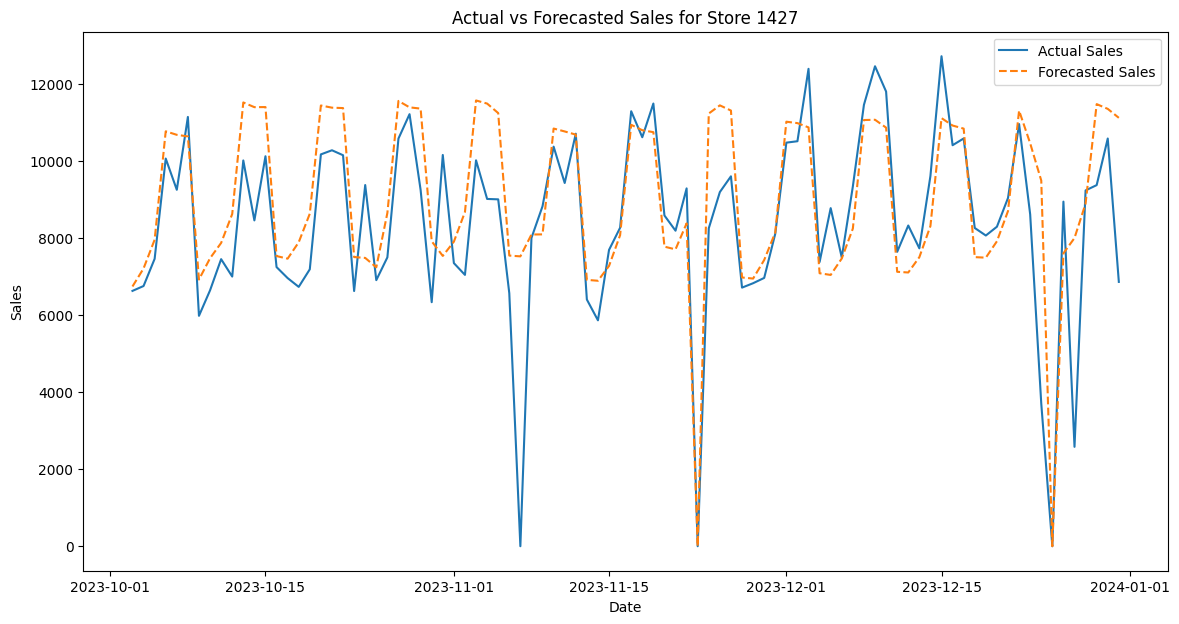

In [207]:
# Combine actual and forecasted sales into a single DataFrame
combined_sales = pd.concat([actual_sales, forecasted_sales], axis=1)
combined_sales.columns = ['Actual Sales', 'Forecasted Sales']

# Plot the actual and forecasted sales
plt.figure(figsize = (14, 7))
plt.plot(combined_sales['Actual Sales'], label = 'Actual Sales')
plt.plot(combined_sales['Forecasted Sales'], label = 'Forecasted Sales', linestyle = '--')
plt.title(f'Actual vs Forecasted Sales for Store {random_store_key}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#<font color = blue> Cluster 4

In [208]:
cluster_4_data = cluster_data(4)
pd.concat([cluster_4_data.head(), cluster_4_data.tail()])

NET_SALES_FINAL_USD_AMOUNT  percentage_ubereats  \
BUSINESS_DATE                                                    
2019-04-23                      125279.09                 8.14   
2019-04-24                      135580.88                 8.14   
2019-04-25                      154638.74                 8.14   
2019-04-26                      196907.75                 8.14   
2019-04-27                      190288.16                 8.14   
2023-12-27                      387284.82               100.00   
2023-12-28                      410213.18               100.00   
2023-12-29                      487665.42               100.00   
2023-12-30                      461366.65               100.00   
2023-12-31                      453029.67               100.00   

               sum_ubereats_age  day_of_year  doordash_age_days  \
BUSINESS_DATE                                                     
2019-04-23               210276          113              96515   
2019-04-24               212193          114              97910   
2019-04-25               212193          115              97910   
2019-04-26               212193          116              97910   
2019-04-27               212193          117              97910   
2023-12-27               239393          361             120361   
2023-12-28               239393          362             120361   
2023-12-29               239393          363             120361   
2023-12-30               239393          364             120361   
2023-12-31               239393          365             120361   

               ubereats_age_days  py_net_sales  PLATFORM_DD  PLATFORM_Inhouse  \
BUSINESS_DATE                                                                   
2019-04-23                 73001          0.00            0                 0   
2019-04-24                 73778          0.00            0                 0   
2019-04-25                 73778          0.00            0                 0   
2019-04-26                 73778          0.00            0                 0   
2019-04-27                 73778          0.00            0                 0   
2023-12-27                 89123     307841.70            0                 0   
2023-12-28                 89123     333681.39            0                 0   
2023-12-29                 89123     401281.91            0                 0   
2023-12-30                 89123     397024.42            0                 0   
2023-12-31                 89123     334858.05            0                 0   

               PLATFORM_UE  FREQUENCY_Weekday  PromotionCash  PromotionKind  \
BUSINESS_DATE                                                                 
2019-04-23               0                  0              0              0   
2019-04-24               0                  0              0              0   
2019-04-25               0                  0              0              0   
2019-04-26               0                  0              0              0   
2019-04-27               0                  0              0              0   
2023-12-27               0                  0              0              0   
2023-12-28               0                  0              0              0   
2023-12-29               0                  0              0              0   
2023-12-30               0                  0              0              0   
2023-12-31               0                  0              0              0   

               PROMOTION_ITEM_DeliveryFee  PROMOTION_COVERAGE_Regional  
BUSINESS_DATE                                                           
2019-04-23                              0                            0  
2019-04-24                              0                            0  
2019-04-25                              0                            0  
2019-04-26                              0                            0  
2019-04-27                              0                

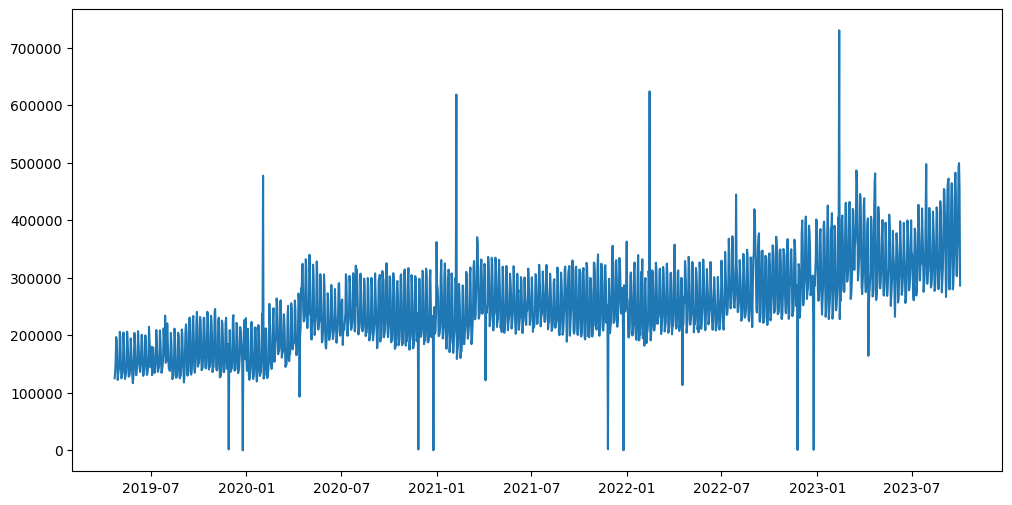

In [209]:
# Split data into train and test sets
train = cluster_4_data.iloc[:-90]  # Assuming the last 90 days are for testing
test = cluster_4_data.iloc[-90:]

plt.figure(figsize = (12, 6))
plt.plot(train['NET_SALES_FINAL_USD_AMOUNT'])

In [210]:
# Normalize all but indicator features
columns = ['percentage_ubereats', 'sum_ubereats_age',
       'day_of_year', 'doordash_age_days', 'ubereats_age_days', 'py_net_sales']
scaler = StandardScaler()
train[columns] = scaler.fit_transform(train[columns])
test[columns] = scaler.transform(test[columns])

##<font color = magenta> ACF-PACF Analysis

<Figure size 1000x500 with 0 Axes>

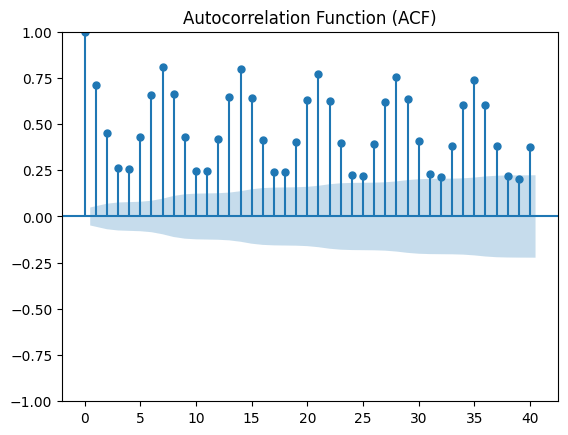

<Figure size 1000x500 with 0 Axes>

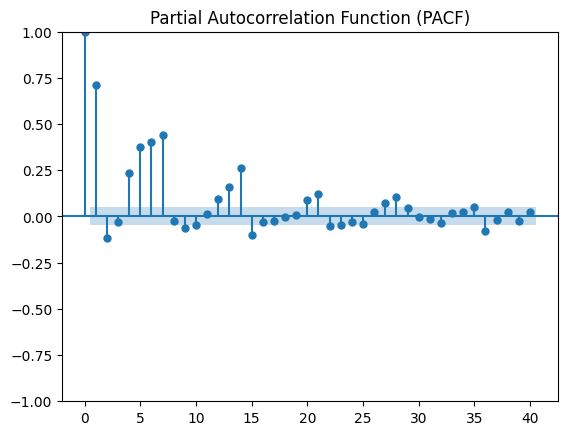

In [211]:
# Extract the sales time series
sales = train['NET_SALES_FINAL_USD_AMOUNT']

# Plot ACF
plt.figure(figsize = (10, 5))
plot_acf(sales, lags = 40, alpha = 0.05)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize = (10, 5))
plot_pacf(sales, lags = 40, alpha = 0.05, method = 'ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

<Figure size 1000x500 with 0 Axes>

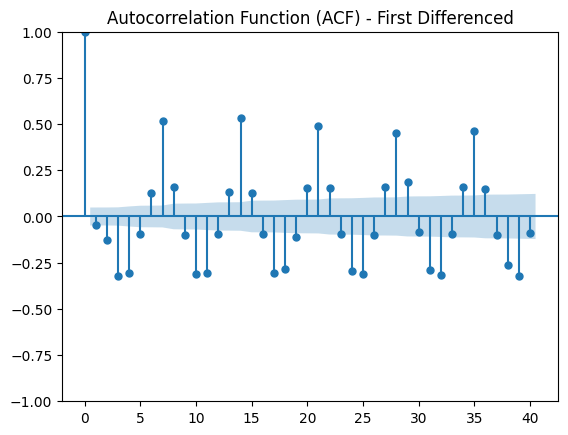

<Figure size 1000x500 with 0 Axes>

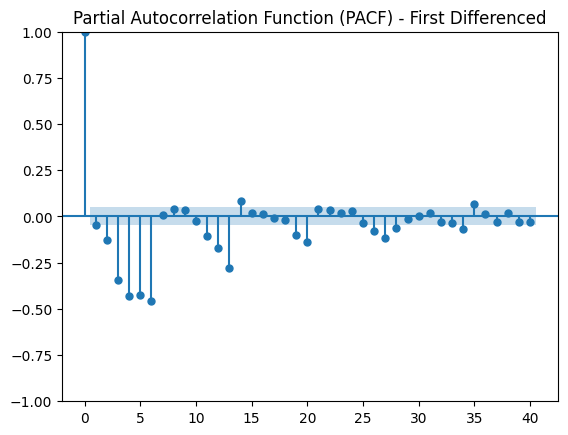

In [212]:
# Compute the first difference
sales_diff = sales.diff().dropna()

# Plot ACF for first differenced data
plt.figure(figsize = (10, 5))
plot_acf(sales_diff, lags = 40, alpha = 0.05)
plt.title('Autocorrelation Function (ACF) - First Differenced')
plt.show()

# Plot PACF for first differenced data
plt.figure(figsize = (10, 5))
plot_pacf(sales_diff, lags = 40, alpha = 0.05, method = 'ywm')
plt.title('Partial Autocorrelation Function (PACF) - First Differenced')
plt.show()

##<font color = magenta> SARIMAX

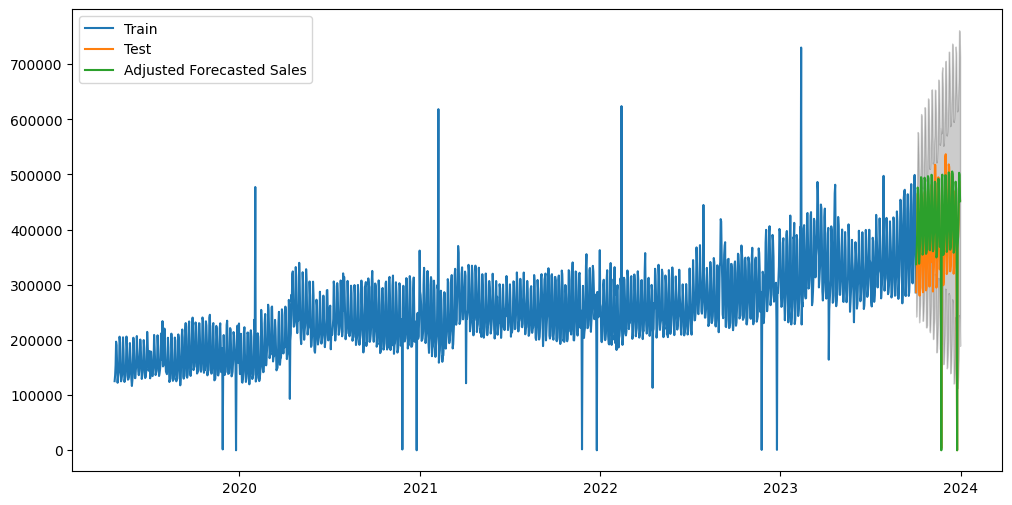

In [213]:
exog_vars = ['percentage_ubereats', 'sum_ubereats_age', 'day_of_year',
             'doordash_age_days', 'ubereats_age_days', 'py_net_sales', 'PLATFORM_DD',
       'PLATFORM_Inhouse', 'PLATFORM_UE', 'FREQUENCY_Weekday', 'PromotionCash',
       'PromotionKind', 'PROMOTION_ITEM_DeliveryFee',
       'PROMOTION_COVERAGE_Regional']


# Fit the SARIMAX model
model = SARIMAX(train['NET_SALES_FINAL_USD_AMOUNT'],
                exog = train[exog_vars],
                order = (0, 1, 1), seasonal_order = (0, 1, 1, 7))
model_fit = model.fit(disp = False)

# Forecast
forecast = model_fit.get_forecast(steps = len(test),
                                  exog = test[exog_vars])

forecast_conf = forecast.conf_int()
forecast_series = forecast.predicted_mean

# Create a DataFrame for the forecasts
forecast_df = pd.DataFrame({
    'BUSINESS_DATE': test.index,
    'Predicted_Sales': forecast_series
})

# Initialize the adjusted predictions with the original forecasts
adjusted_forecast = forecast_series.copy()

# Adjust the forecasts based on special dates
for i in range(len(forecast_df)):
    date = forecast_df['BUSINESS_DATE'].iloc[i]

    if date in downspike_dates:
        adjusted_forecast[i] = 0 # Set downspikes sales to zero
    elif date in upspike_dates:
        if i > 0:
            adjusted_forecast[i] = adjusted_forecast[i-1] + forecast_series[i]  # Add the forecasted value to the previous value for upspike dates
    else:
        adjusted_forecast[i] = forecast_series[i]  # Keep the original forecast for other dates

# Create a DataFrame for the adjusted predictions
adjusted_predictions_df = pd.DataFrame({
    'BUSINESS_DATE': forecast_df['BUSINESS_DATE'],
    'Adjusted_Predicted_Sales': adjusted_forecast
})

# Plot the results
plt.figure(figsize = (12, 6))
plt.plot(train['NET_SALES_FINAL_USD_AMOUNT'], label = 'Train')
plt.plot(test['NET_SALES_FINAL_USD_AMOUNT'], label = 'Test')
plt.plot(adjusted_predictions_df['BUSINESS_DATE'], adjusted_predictions_df['Adjusted_Predicted_Sales'], label='Adjusted Forecasted Sales')
#plt.plot(forecast_series, label = 'Forecast')
plt.fill_between(forecast_conf.index, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1],
                 color = 'k', alpha = 0.2)
plt.legend()
plt.show()

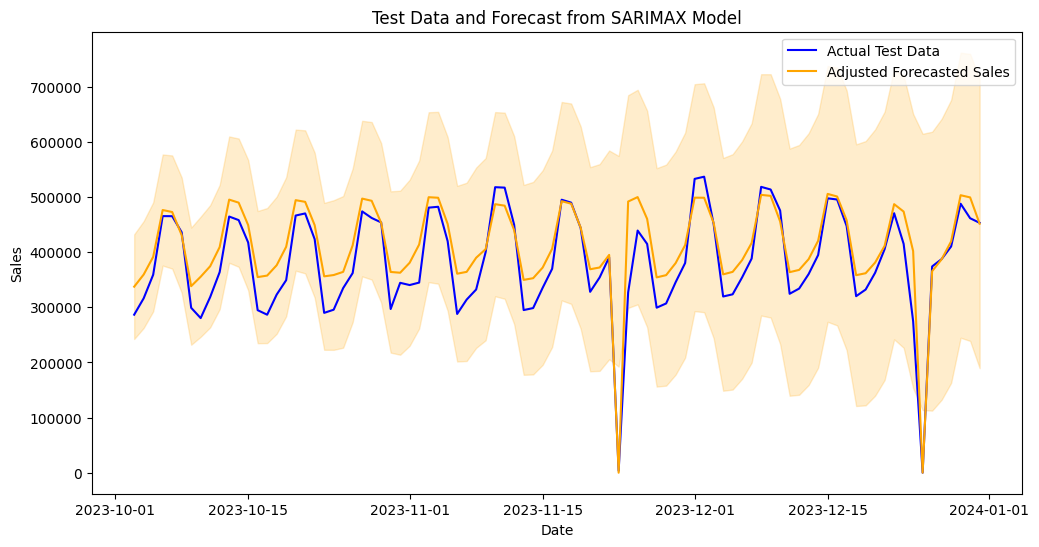

In [214]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['NET_SALES_FINAL_USD_AMOUNT'], label = 'Actual Test Data', color = 'blue')
plt.plot(adjusted_predictions_df['BUSINESS_DATE'], adjusted_predictions_df['Adjusted_Predicted_Sales'],
         label='Adjusted Forecasted Sales', color = 'orange')
plt.fill_between(test.index, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1],
                 color = 'orange', alpha = 0.2)
plt.title('Test Data and Forecast from SARIMAX Model')
plt.xlabel('Date')
plt.ylabel('Sales')
#plt.axvline(x = test[test.index == '2023-11-23'].index, color = 'red')
#plt.axvline(x = test[test.index == '2023-12-25'].index, color = 'red')
plt.legend()
plt.show()

In [215]:
# Define dates to exclude
exclude_dates = pd.to_datetime(['2023-11-23', '2023-12-25'])

# Filter out the excluded dates
mask = ~test.index.isin(exclude_dates)

actual = test['NET_SALES_FINAL_USD_AMOUNT']
actual_excl = test.loc[mask, 'NET_SALES_FINAL_USD_AMOUNT']

mape = np.mean(np.abs((actual - adjusted_predictions_df['Adjusted_Predicted_Sales']) / actual)) * 100
print(f"MAPE: {mape:.2f}%")

smape = np.mean(np.abs((actual - adjusted_predictions_df['Adjusted_Predicted_Sales']) / (actual + adjusted_predictions_df['Adjusted_Predicted_Sales'])) * 200)
print(f"sMAPE: {smape:.2f}%")

mape_excl = np.mean(np.abs((actual_excl - adjusted_predictions_df['Adjusted_Predicted_Sales'][mask]) / actual_excl)) * 100
print(f"MAPE excluding the 2 spikes: {mape_excl:.2f}%")

MAPE: 11.00%
sMAPE: 11.36%
MAPE excluding the 2 spikes: 9.99%


In [216]:
cluster_forecasts.append(adjusted_predictions_df['Adjusted_Predicted_Sales'])

##<font color = magenta> Disaggregation: Simple Recent Proportions

In [217]:
disaggregated_forecasts = disaggregate(c_number = 4,
                                       forecast_series = adjusted_predictions_df['Adjusted_Predicted_Sales'],
                                       period = '1Y')
pd.concat([disaggregated_forecasts.head(), disaggregated_forecasts.tail()])

21           26           244          319          1359  \
2023-10-03  4289.436721  4640.354897  3275.130010  5344.367337  5827.681888   
2023-10-04  4569.438682  4943.263777  3488.920977  5693.232102  6208.096023   
2023-10-05  4976.583823  5383.717401  3799.790062  6200.509242  6761.248457   
2023-10-06  6056.811288  6552.318113  4624.580266  7546.404463  8228.858879   
2023-10-07  6010.912069  6502.663885  4589.534660  7489.216933  8166.499630   
2023-12-27  4920.750076  5323.315903  3757.159108  6130.943918  6685.392036   
2023-12-28  5333.896494  5770.261767  4072.610371  6645.698270  7246.697880   
2023-12-29  6398.032584  6921.454672  4885.114266  7971.544654  8692.446360   
2023-12-30  6347.747920  6867.056227  4846.720224  7908.893137  8624.128992   
2023-12-31  5741.176781  6210.861594  4383.582645  7153.143794  7800.033926   

                   1374         1402         1433         1455         1478  \
2023-10-03  4238.691595  2937.857353  4060.683619  2985.738667  1571.611095   
2023-10-04  4515.381062  3129.632142  4325.753243  3180.639009  1674.201299   
2023-10-05  4917.709573  3408.487951  4711.185576  3464.039621  1823.375622   
2023-10-06  5985.157673  4148.341318  5733.805155  4215.951147  2219.161265   
2023-10-07  5939.801452  4116.904705  5690.353713  4184.002179  2202.344203   
2023-12-27  4862.536353  3370.247129  4658.329409  3425.175548  1802.918639   
2023-12-28  5270.795144  3653.213243  5049.442975  3712.753456  1954.291776   
2023-12-29  6322.342234  4382.045545  6056.829322  4453.464294  2344.181683   
2023-12-30  6272.652450  4347.605319  6009.226309  4418.462760  2325.757834   
2023-12-31  5673.257202  3932.161614  5435.003247  3996.248138  2103.515616   

            ...         2327         2329         2350         2359  \
2023-10-03  ...  4268.953689  2468.018659  3755.056446  3692.413481   
2023-10-04  ...  4547.618578  2629.123744  4000.175617  3933.443501   
2023-10-05  ...  4952.819508  2863.383361  4356.598403  4283.920336   
2023-10-06  ...  6027.888642  3484.915211  5302.250564  5213.796848   
2023-10-07  ...  5982.208602  3458.506118  5262.069493  5174.286089   
2023-12-27  ...  4897.252380  2831.258227  4307.720453  4235.857783   
2023-12-28  ...  5308.425930  3068.970806  4669.396873  4591.500610   
2023-12-29  ...  6367.480529  3681.244141  5600.962332  5507.525417   
2023-12-30  ...  6317.435986  3652.311790  5556.942158  5464.239601   
2023-12-31  ...  5713.761361  3303.308183  5025.937969  4942.093781   

                   2375         2378         2405         2409         2420  \
2023-10-03  3738.378022  1889.247323  2563.036254  3132.384874  4921.554275   
2023-10-04  3982.408473  2012.571897  2730.343811  3336.857854  5242.819033   
2023-10-05  4337.248175  2191.895644  2973.622317  3634.177843  5709.963565   
2023-10-06  5278.700137  2667.672997  3619.082860  4423.019920  6949.379937   
2023-10-07  5238.697534  2647.457061  3591.657030  4389.501761  6896.716728   
2023-12-27  4288.587321  2167.304127  2940.260380  3593.404941  5645.901816   
2023-12-28  4648.657323  2349.271088  3187.124785  3895.107396  6119.932009   
2023-12-29  5576.085149  2817.961126  3822.970365  4672.198657  7340.885683   
2023-12-30  5532.260494  2795.813657  3792.924132  4635.478003  7283.190765   
2023-12-31  5003.614809  2528.654359  3430.484044  4192.526077  6587.231603   

                   2444  
2023-10-03  3479.986430  
2023-10-04  3707.149829  
2023-10-05  4037.463495  
2023-10-06  4913.843580  
2023-10-07  4876.605903  
2023-12-27  3992.166013  
2023-12-28  4327.348467  
2023-12-29  5190.673746  
2023-12-30  5149.878192  
2023-12-31  4657.771776  

[10 rows x 86 columns]

In [218]:
# Select a random store_key from the list of store keys
random_store_key = random.choice(list(disaggregated_forecasts.columns))
print(f"Randomly selected store_key: {random_store_key}")

Randomly selected store_key: 2279


In [219]:
# Extract actual sales for the selected store
actual_sales = df[df['STORE_KEY'] == random_store_key].set_index('BUSINESS_DATE')['NET_SALES_FINAL_USD_AMOUNT'].sort_index()[-90:]

# Extract forecasted sales for the selected store
forecasted_sales = disaggregated_forecasts[random_store_key]

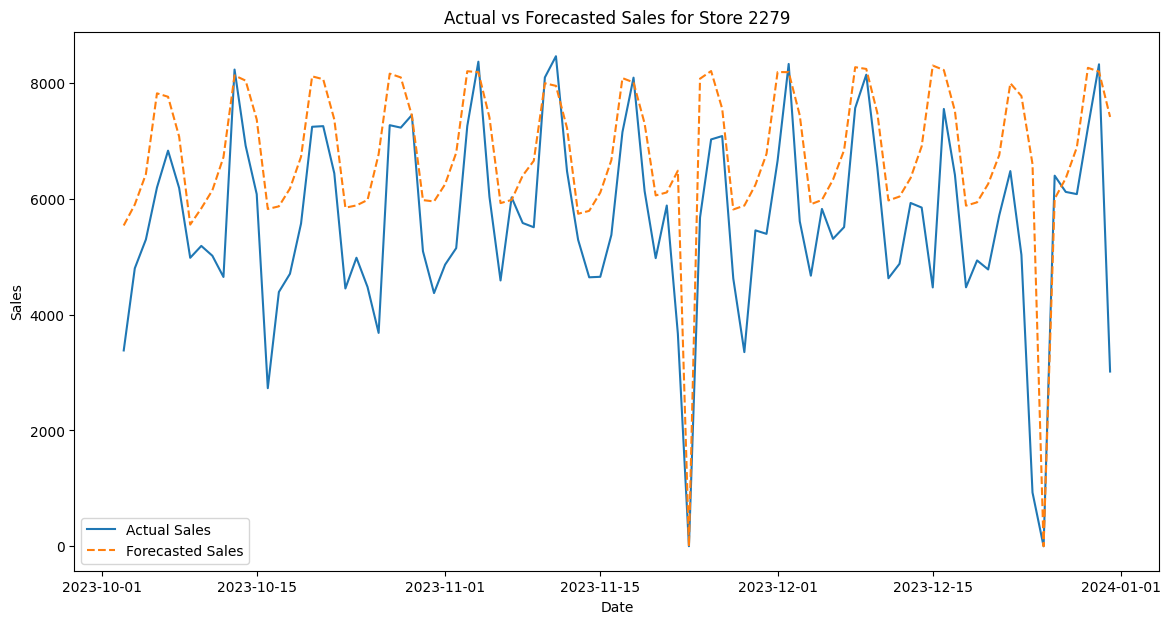

In [220]:
# Combine actual and forecasted sales into a single DataFrame
combined_sales = pd.concat([actual_sales, forecasted_sales], axis=1)
combined_sales.columns = ['Actual Sales', 'Forecasted Sales']

# Plot the actual and forecasted sales
plt.figure(figsize = (14, 7))
plt.plot(combined_sales['Actual Sales'], label = 'Actual Sales')
plt.plot(combined_sales['Forecasted Sales'], label = 'Forecasted Sales', linestyle = '--')
plt.title(f'Actual vs Forecasted Sales for Store {random_store_key}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#<font color = blue> Cluster 5

In [221]:
cluster_5_data = cluster_data(5)
pd.concat([cluster_5_data.head(), cluster_5_data.tail()])

NET_SALES_FINAL_USD_AMOUNT  percentage_ubereats  \
BUSINESS_DATE                                                    
2019-12-28                        1188.08                  0.0   
2019-12-29                        1104.83                  0.0   
2019-12-30                        1130.16                  0.0   
2019-12-31                        2039.39                  0.0   
2020-01-01                        1651.96                  0.0   
2023-12-27                      315189.19                100.0   
2023-12-28                      326311.66                100.0   
2023-12-29                      378308.45                100.0   
2023-12-30                      370376.36                100.0   
2023-12-31                      385015.58                100.0   

               sum_ubereats_age  day_of_year  doordash_age_days  \
BUSINESS_DATE                                                     
2019-12-28                 1669          362               1395   
2019-12-29                 1669          363               1395   
2019-12-30                 1669          364               1395   
2019-12-31                 1669          365               1395   
2020-01-01                 1669            1               1395   
2023-12-27                63116          361              62568   
2023-12-28                63116          362              62568   
2023-12-29                63116          363              62568   
2023-12-30                63116          364              62568   
2023-12-31                63116          365              62568   

               ubereats_age_days  py_net_sales  PLATFORM_DD  PLATFORM_Inhouse  \
BUSINESS_DATE                                                                   
2019-12-28                   734          0.00            0                 0   
2019-12-29                   734          0.00            0                 0   
2019-12-30                   734          0.00            0                 0   
2019-12-31                   734          0.00            0                 0   
2020-01-01                   734          0.00            0                 0   
2023-12-27                 50566     180420.68            0                 0   
2023-12-28                 50566     199208.87            0                 0   
2023-12-29                 50566     234294.43            0                 0   
2023-12-30                 50566     254352.20            0                 0   
2023-12-31                 50566     219691.19            0                 0   

               PLATFORM_UE  FREQUENCY_Weekday  PromotionCash  PromotionKind  \
BUSINESS_DATE                                                                 
2019-12-28               0                  0              0              0   
2019-12-29               0                  0              0              0   
2019-12-30               0                  0              0              0   
2019-12-31               0                  0              0              0   
2020-01-01               0                  0              0              0   
2023-12-27               0                  0              0              0   
2023-12-28               0                  0              0              0   
2023-12-29               0                  0              0              0   
2023-12-30               0                  0              0              0   
2023-12-31               0                  0              0              0   

               PROMOTION_ITEM_DeliveryFee  PROMOTION_COVERAGE_Regional  
BUSINESS_DATE                                                           
2019-12-28                              0                            0  
2019-12-29                              0                            0  
2019-12-30                              0                            0  
2019-12-31                              0                            0  
2020-01-01                              0                

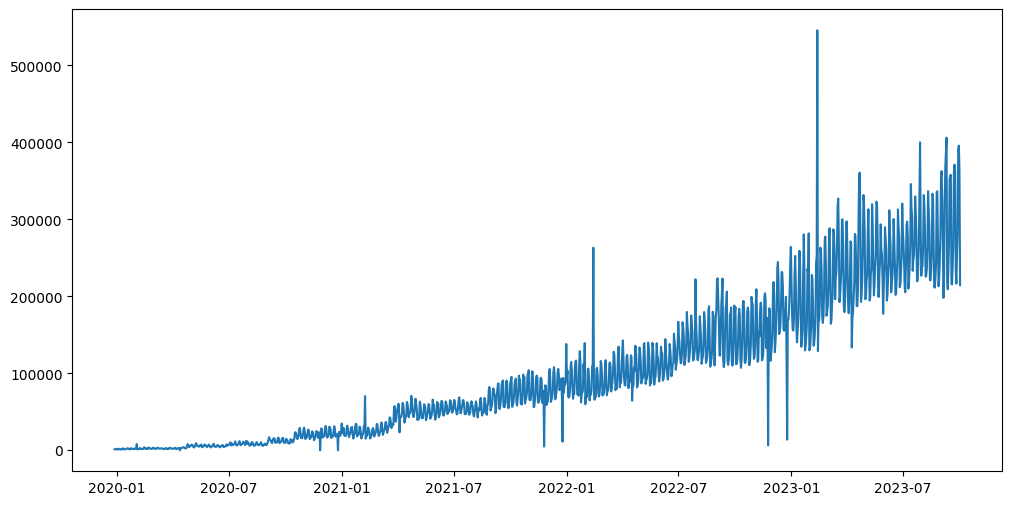

In [222]:
# Split data into train and test sets
train = cluster_5_data.iloc[:-90]  # Assuming the last 90 days are for testing
test = cluster_5_data.iloc[-90:]

plt.figure(figsize = (12, 6))
plt.plot(train['NET_SALES_FINAL_USD_AMOUNT'])

In [223]:
# Normalize all but indicator features
columns = ['percentage_ubereats', 'sum_ubereats_age',
       'day_of_year', 'doordash_age_days', 'ubereats_age_days', 'py_net_sales']
scaler = StandardScaler()
train[columns] = scaler.fit_transform(train[columns])
test[columns] = scaler.transform(test[columns])

##<font color = magenta> ACF-PACF Analysis

<Figure size 1000x500 with 0 Axes>

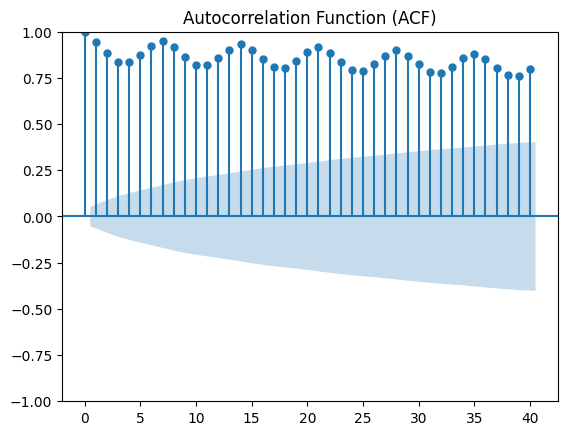

<Figure size 1000x500 with 0 Axes>

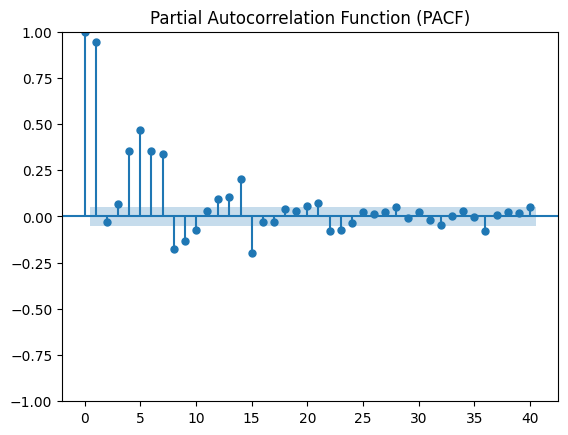

In [224]:
# Extract the sales time series
sales = train['NET_SALES_FINAL_USD_AMOUNT']

# Plot ACF
plt.figure(figsize = (10, 5))
plot_acf(sales, lags = 40, alpha = 0.05)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize = (10, 5))
plot_pacf(sales, lags = 40, alpha = 0.05, method = 'ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

<Figure size 1000x500 with 0 Axes>

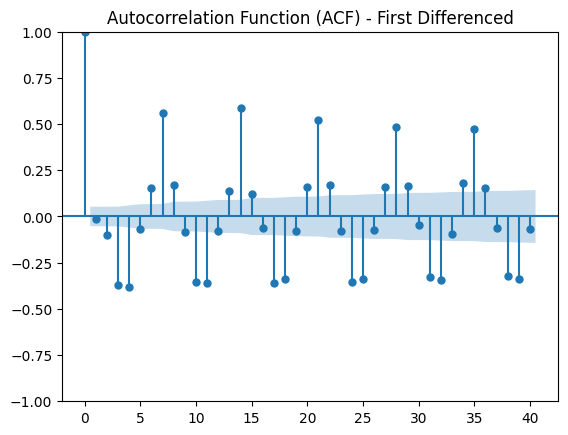

<Figure size 1000x500 with 0 Axes>

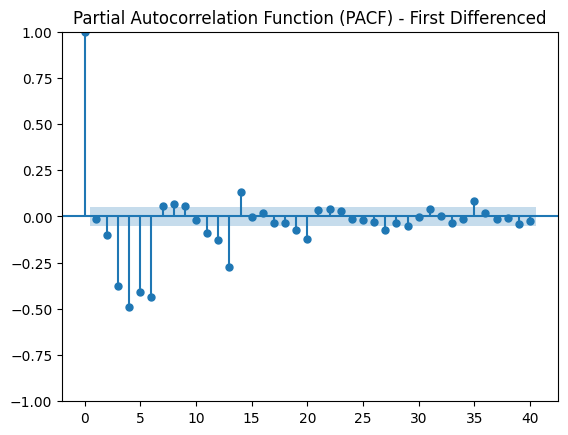

In [225]:
# Compute the first difference
sales_diff = sales.diff().dropna()

# Plot ACF for first differenced data
plt.figure(figsize = (10, 5))
plot_acf(sales_diff, lags = 40, alpha = 0.05)
plt.title('Autocorrelation Function (ACF) - First Differenced')
plt.show()

# Plot PACF for first differenced data
plt.figure(figsize = (10, 5))
plot_pacf(sales_diff, lags = 40, alpha = 0.05, method = 'ywm')
plt.title('Partial Autocorrelation Function (PACF) - First Differenced')
plt.show()

##<font color = magenta> SARIMAX

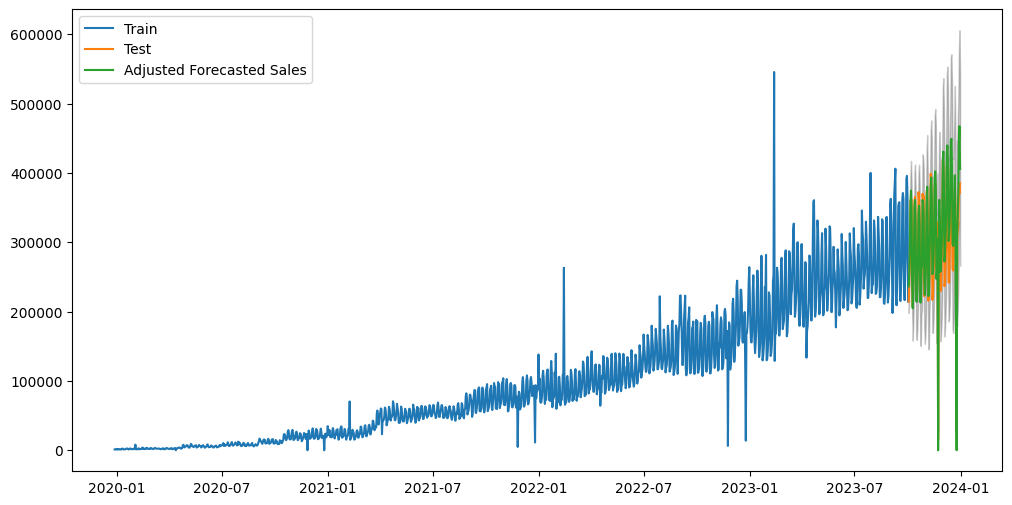

In [226]:
exog_vars = ['percentage_ubereats', 'sum_ubereats_age', 'day_of_year',
             'doordash_age_days', 'ubereats_age_days', 'py_net_sales', 'PLATFORM_DD',
       'PLATFORM_Inhouse', 'PLATFORM_UE', 'FREQUENCY_Weekday', 'PromotionCash',
       'PromotionKind', 'PROMOTION_ITEM_DeliveryFee',
       'PROMOTION_COVERAGE_Regional']

# Fit the SARIMAX model
model = SARIMAX(train['NET_SALES_FINAL_USD_AMOUNT'],
                exog = train[exog_vars],
                order = (0, 1, 1), seasonal_order = (0, 1, 1, 7))
model_fit = model.fit(disp = False)

# Forecast
forecast = model_fit.get_forecast(steps = len(test),
                                  exog = test[exog_vars])

forecast_conf = forecast.conf_int()
forecast_series = forecast.predicted_mean

# Create a DataFrame for the forecasts
forecast_df = pd.DataFrame({
    'BUSINESS_DATE': test.index,
    'Predicted_Sales': forecast_series
})

# Initialize the adjusted predictions with the original forecasts
adjusted_forecast = forecast_series.copy()

# Adjust the forecasts based on special dates
for i in range(len(forecast_df)):
    date = forecast_df['BUSINESS_DATE'].iloc[i]

    if date in downspike_dates:
        adjusted_forecast[i] = 0 # Set downspikes sales to zero
    elif date in upspike_dates:
        if i > 0:
            adjusted_forecast[i] = adjusted_forecast[i-1] + forecast_series[i]  # Add the forecasted value to the previous value for upspike dates
    else:
        adjusted_forecast[i] = forecast_series[i]  # Keep the original forecast for other dates

# Create a DataFrame for the adjusted predictions
adjusted_predictions_df = pd.DataFrame({
    'BUSINESS_DATE': forecast_df['BUSINESS_DATE'],
    'Adjusted_Predicted_Sales': adjusted_forecast
})

# Plot the results
plt.figure(figsize = (12, 6))
plt.plot(train['NET_SALES_FINAL_USD_AMOUNT'], label = 'Train')
plt.plot(test['NET_SALES_FINAL_USD_AMOUNT'], label = 'Test')
plt.plot(adjusted_predictions_df['BUSINESS_DATE'], adjusted_predictions_df['Adjusted_Predicted_Sales'], label='Adjusted Forecasted Sales')
#plt.plot(forecast_series, label = 'Forecast')
plt.fill_between(forecast_conf.index, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1],
                 color = 'k', alpha = 0.2)
plt.legend()
plt.show()

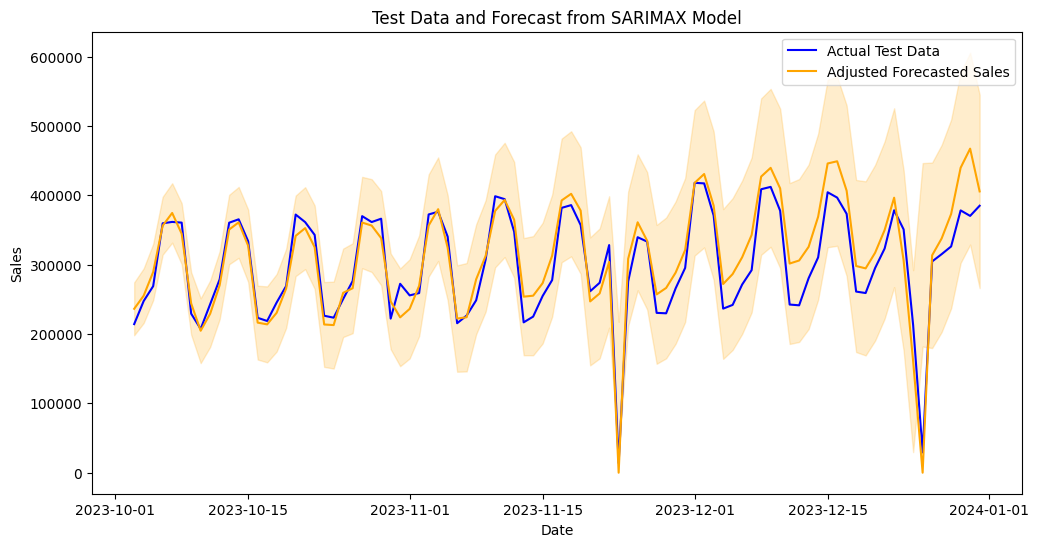

In [227]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['NET_SALES_FINAL_USD_AMOUNT'], label = 'Actual Test Data', color = 'blue')
plt.plot(adjusted_predictions_df['BUSINESS_DATE'], adjusted_predictions_df['Adjusted_Predicted_Sales'],
         label='Adjusted Forecasted Sales', color = 'orange')
plt.fill_between(test.index, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1],
                 color = 'orange', alpha = 0.2)
plt.title('Test Data and Forecast from SARIMAX Model')
plt.xlabel('Date')
plt.ylabel('Sales')
#plt.axvline(x = test[test.index == '2023-11-23'].index, color = 'red')
#plt.axvline(x = test[test.index == '2023-12-25'].index, color = 'red')
plt.legend()
plt.show()

In [228]:
# Define dates to exclude
exclude_dates = pd.to_datetime(['2023-11-23', '2023-12-25'])

# Filter out the excluded dates
mask = ~test.index.isin(exclude_dates)

actual = test['NET_SALES_FINAL_USD_AMOUNT']
actual_excl = test.loc[mask, 'NET_SALES_FINAL_USD_AMOUNT']

mape = np.mean(np.abs((actual - adjusted_predictions_df['Adjusted_Predicted_Sales']) / actual)) * 100
print(f"MAPE: {mape:.2f}%")

smape = np.mean(np.abs((actual - adjusted_predictions_df['Adjusted_Predicted_Sales']) / (actual + adjusted_predictions_df['Adjusted_Predicted_Sales'])) * 200)
print(f"sMAPE: {smape:.2f}%")

mape_excl = np.mean(np.abs((actual_excl - adjusted_predictions_df['Adjusted_Predicted_Sales'][mask]) / actual_excl)) * 100
print(f"MAPE excluding the 2 spikes: {mape_excl:.2f}%")

MAPE: 10.03%
sMAPE: 11.98%
MAPE excluding the 2 spikes: 7.98%


In [229]:
cluster_forecasts.append(adjusted_predictions_df['Adjusted_Predicted_Sales'])

##<font color = magenta> Disaggregation: Simple Recent Proportions

In [230]:
disaggregated_forecasts = disaggregate(c_number = 5,
                                       forecast_series = adjusted_predictions_df['Adjusted_Predicted_Sales'],
                                       period = '1Y')
pd.concat([disaggregated_forecasts.head(), disaggregated_forecasts.tail()])

10            58            89            104   \
2023-10-03   6464.275831   5726.733734   6541.095957   5756.183262   
2023-10-04   6981.796016   6185.207410   7064.766246   6217.014624   
2023-10-05   7916.054465   7012.871562   8010.127230   7048.935009   
2023-10-06   9741.814620   8630.321459   9857.584345   8674.702586   
2023-10-07  10244.420275   9075.582279  10366.162862   9122.253144   
2023-12-27   9237.624032   8183.656538   9347.402059   8225.740706   
2023-12-28  10204.450260   9040.172646  10325.717851   9086.661418   
2023-12-29  12027.273410  10655.020635  12170.203057  10709.813707   
2023-12-30  12781.212423  11322.938913  12933.101727  11381.166731   
2023-12-31  11094.460679   9828.637251  11226.304971   9879.180675   

                   106           109          114           115          174   \
2023-10-03  3548.991283   5786.217162  4160.365195   6895.520260  4933.800932   
2023-10-04  3833.118179   6249.452992  4493.437766   7447.565225  5328.793602   
2023-10-05  4346.041076   7085.714069  5094.720328   8444.149874  6041.858039   
2023-10-06  5348.412734   8719.964374  6269.767496  10391.710046  7435.353210   
2023-10-07  5624.351313   9169.850106  6593.241173  10927.845502  7818.962498   
2023-12-27  5071.604000   8268.659957  5945.273766   9853.883921  7050.534236   
2023-12-28  5602.407132   9134.072674  6567.516735  10885.209009  7788.455740   
2023-12-29  6603.166326  10765.694046  7740.673666  12829.636242  9179.709268   
2023-12-30  7017.090957  11440.549973  8225.903831  13633.871995  9755.146503   
2023-12-31  6091.037151   9930.727040  7140.321558  11834.593757  8467.748262   

                    179   ...         640          648          664   \
2023-10-03   6111.854636  ...  2823.921741  2161.563456   711.256207   
2023-10-04   6601.160511  ...  3050.000662  2334.614970   768.198308   
2023-10-05   7484.484797  ...  3458.131876  2647.017933   870.993599   
2023-10-06   9210.707650  ...  4255.716004  3257.526602  1071.879712   
2023-10-07   9685.912110  ...  4475.279505  3425.590905  1127.180785   
2023-12-27   8734.004665  ...  4035.460123  3088.932318  1016.404250   
2023-12-28   9648.121191  ...  4457.818586  3412.225491  1122.782934   
2023-12-29  11371.567160  ...  5254.119681  4021.752066  1323.345892   
2023-12-30  12084.402715  ...  5583.478271  4273.858731  1406.300861   
2023-12-31  10489.609773  ...  4846.620029  3709.832531  1220.709671   

                   670          680          789           1735         2371  \
2023-10-03  1207.613065   946.058495  3713.033662   6437.476087  3116.247265   
2023-10-04  1304.292748  1021.798513  4010.293544   6952.850726  3365.729327   
2023-10-05  1478.824705  1158.528931  4546.924895   7883.235904  3816.109294   
2023-10-06  1819.901087  1425.732242  5595.628430   9701.426781  4696.257394   
2023-10-07  1913.794537  1499.289491  5884.321513  10201.948721  4938.549577   
2023-12-27  1725.711551  1351.943035  5306.024973   9199.326477  4453.201160   
2023-12-28  1906.327604  1493.439807  5861.363022  10162.144415  4919.281146   
2023-12-29  2246.855315  1760.213282  6908.379563  11977.410463  5798.013398   
2023-12-30  2387.701193  1870.553624  7341.436724  12728.223778  6161.466389   
2023-12-31  2072.593438  1623.694447  6372.578622  11048.465008  5348.330371   

                    2396          2399  
2023-10-03   5804.159472   6160.981951  
2023-10-04   6268.831736   6654.220885  
2023-10-05   7107.685950   7544.645364  
2023-10-06   8747.003853   9284.743661  
2023-10-07   9198.284623   9763.767832  
2023-12-27   8294.300000   8804.208920  
2023-12-28   9162.396250   9725.673148  
2023-12-29  10799.077068  11462.972240  
2023-12-30  11476.025635  12181.537594  
2023-12-31   9961.520937  10573.925647  

[10 rows x 73 columns]

In [231]:
# Select a random store_key from the list of store keys
random_store_key = random.choice(list(disaggregated_forecasts.columns))
print(f"Randomly selected store_key: {random_store_key}")

Randomly selected store_key: 210


In [232]:
# Extract actual sales for the selected store
actual_sales = df[df['STORE_KEY'] == random_store_key].set_index('BUSINESS_DATE')['NET_SALES_FINAL_USD_AMOUNT'].sort_index()[-90:]

# Extract forecasted sales for the selected store
forecasted_sales = disaggregated_forecasts[random_store_key]

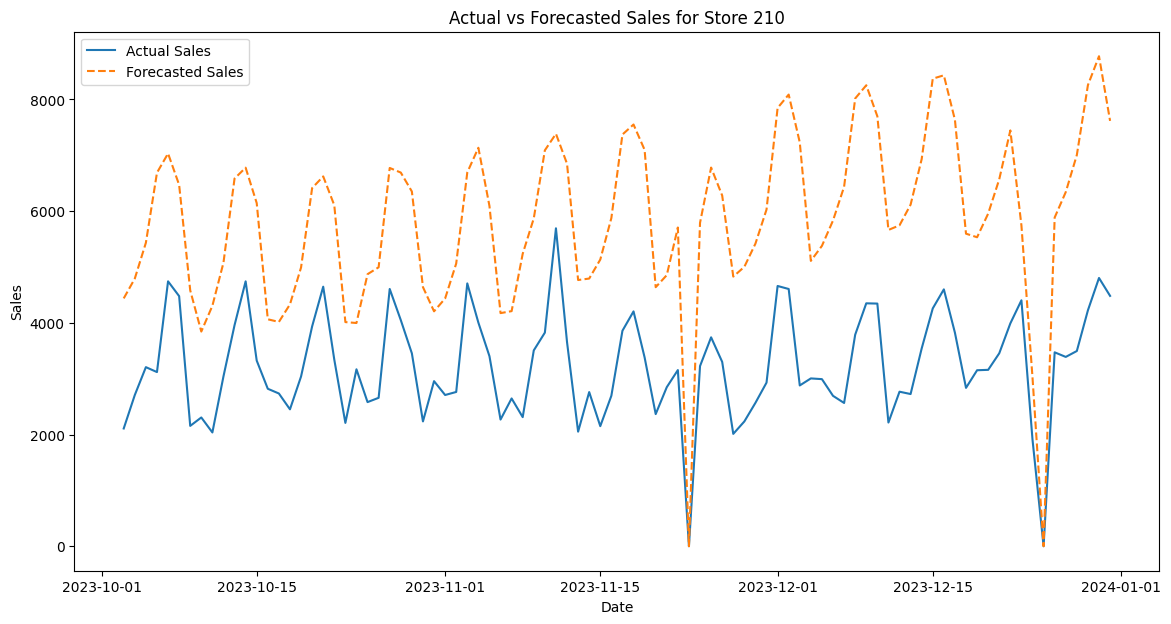

In [233]:
# Combine actual and forecasted sales into a single DataFrame
combined_sales = pd.concat([actual_sales, forecasted_sales], axis=1)
combined_sales.columns = ['Actual Sales', 'Forecasted Sales']

# Plot the actual and forecasted sales
plt.figure(figsize = (14, 7))
plt.plot(combined_sales['Actual Sales'], label = 'Actual Sales')
plt.plot(combined_sales['Forecasted Sales'], label = 'Forecasted Sales', linestyle = '--')
plt.title(f'Actual vs Forecasted Sales for Store {random_store_key}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#<font color = green> User Interaction: Simply input the **STORE_KEY** !!

In [234]:
list_of_stores = df['STORE_KEY'].unique()
list_of_stores

array([1402, 2104, 1753, 2443, 1859, 2255, 2439, 1805,  394, 1839, 2084,
       2329, 2409, 1072,  862, 1280, 2016, 1913, 2133, 1198,  828,  319,
        342, 2041,  901, 1110, 1167, 1635, 1842,  839,  932, 1331, 2102,
       1895, 2153, 2033, 1599, 1610, 1202, 2286,  187, 1427, 1211, 1175,
       1984, 1374, 2405, 1137, 1910, 2114, 1982, 2326, 1005, 1310,  179,
       2195, 1348, 2108, 2335, 1042,  825, 1641, 2092, 1400,   38,  990,
       1657, 1142, 2168, 2239, 2161, 2396,   26, 1322, 1506, 2330, 2081,
       1630, 2420, 1686, 2327, 1763,  210,  282, 1559, 2346, 1847, 1336,
       2118,  976, 2223, 2359, 1956, 2006,  268, 1444, 1130, 2059, 2467,
        435, 1263, 2278, 2279,  885, 2169, 1534,  854,  244, 1118, 1700,
        946, 1124, 1699, 2429, 1834, 1195,  960, 1858, 1498, 1752, 1084,
        460, 1229, 2263, 1291,  874, 1627, 1530, 2444, 1399, 1117,  917,
       2032, 1793, 2115,  217,  956, 1943, 2229, 2321, 2270, 2206, 1535,
       1993, 1678, 1061, 1743, 1356, 1185, 2368, 10

MAPE: 15.93%
sMAPE: 13.91%
MAPE excluding the 2 spikes: 15.93%


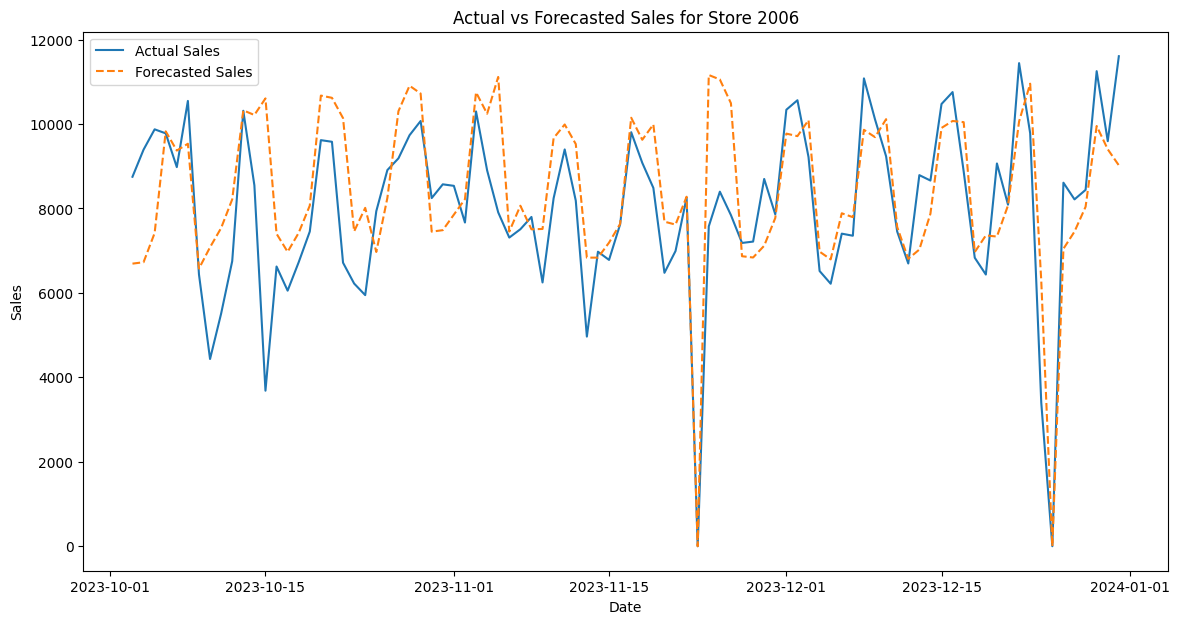

In [277]:
# Enter the store key
store_key = 2006

# Extract actual sales for the selected store
actual_sales = df[df['STORE_KEY'] == store_key].set_index('BUSINESS_DATE')['NET_SALES_FINAL_USD_AMOUNT'].sort_index()[-90:]

# Extract forecasted sales for the selected store
forecast_dis = estimate_proportion_forecast(store_key)
forecasted_sales = forecast_dis['Forecast_Sales']

# Combine actual and forecasted sales into a single DataFrame

combined_sales = pd.concat([actual_sales, forecasted_sales], axis=1)
combined_sales.columns = ['Actual Sales', 'Forecasted Sales']

mape = np.mean(np.abs((actual_sales - forecasted_sales) / actual_sales)) * 100
print(f"MAPE: {mape:.2f}%")


smape = np.mean(np.abs(actual_sales - forecasted_sales)*2 / (actual_sales + forecasted_sales)) * 100
print(f"sMAPE: {smape:.2f}%")

# Define dates to exclude
exclude_dates = pd.to_datetime(['2023-11-23', '2023-12-25'])

# Filter out the excluded dates
mask = ~combined_sales.index.isin(exclude_dates)

actual = combined_sales['Actual Sales']
actual_excl = combined_sales.loc[mask, 'Actual Sales']

mape_excl = np.mean(np.abs((actual_excl - forecasted_sales[mask]) / actual_excl)) * 100
print(f"MAPE excluding the 2 spikes: {mape_excl:.2f}%")

# Plot the actual and forecasted sales
plt.figure(figsize = (14, 7))
plt.plot(combined_sales['Actual Sales'], label = 'Actual Sales')
plt.plot(combined_sales['Forecasted Sales'], label = 'Forecasted Sales', linestyle = '--')
plt.title(f'Actual vs Forecasted Sales for Store {store_key}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#<font color = cyan> THE END

In [ ]:
import ipywidgets as widgets
from IPython.display import display

store_key_widget = widgets.Dropdown(
    options=list_of_stores,
    description='Store Key:',
)

display(store_key_widget)

def on_button_clicked(b):
    store_key = store_key_widget.value
    # Your existing code here to calculate and plot the forecasts
    # Enter the store key

    # Extract actual sales for the selected store
    actual_sales = df[df['STORE_KEY'] == store_key].set_index('BUSINESS_DATE')['NET_SALES_FINAL_USD_AMOUNT'].sort_index()[-90:]

    # Extract forecasted sales for the selected store
    forecast_dis = estimate_proportion_forecast(store_key)
    forecasted_sales = forecast_dis['Forecast_Sales']

    # Combine actual and forecasted sales into a single DataFrame

    combined_sales = pd.concat([actual_sales, forecasted_sales], axis=1)
    combined_sales.columns = ['Actual Sales', 'Forecasted Sales']

    mape = np.mean(np.abs((actual_sales - forecasted_sales) / actual_sales)) * 100
    print(f"MAPE: {mape:.2f}%")


    smape = np.mean(np.abs(actual_sales - forecasted_sales)*2 / (actual_sales + forecasted_sales)) * 100
    print(f"sMAPE: {smape:.2f}%")

    # Define dates to exclude
    exclude_dates = pd.to_datetime(['2023-11-23', '2023-12-25'])

    # Filter out the excluded dates
    mask = ~combined_sales.index.isin(exclude_dates)

    actual = combined_sales['Actual Sales']
    actual_excl = combined_sales.loc[mask, 'Actual Sales']

    mape_excl = np.mean(np.abs((actual_excl - forecasted_sales[mask]) / actual_excl)) * 100
    print(f"MAPE excluding the 2 spikes: {mape_excl:.2f}%")

    # Plot the actual and forecasted sales
    plt.figure(figsize = (14, 7))
    plt.plot(combined_sales['Actual Sales'], label = 'Actual Sales')
    plt.plot(combined_sales['Forecasted Sales'], label = 'Forecasted Sales', linestyle = '--')
    plt.title(f'Actual vs Forecasted Sales for Store {store_key}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

button = widgets.Button(description="Submit")
button.on_click(on_button_clicked)
display(button)


In [260]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.4 MB/s eta 0:00:00


DeltaGenerator()

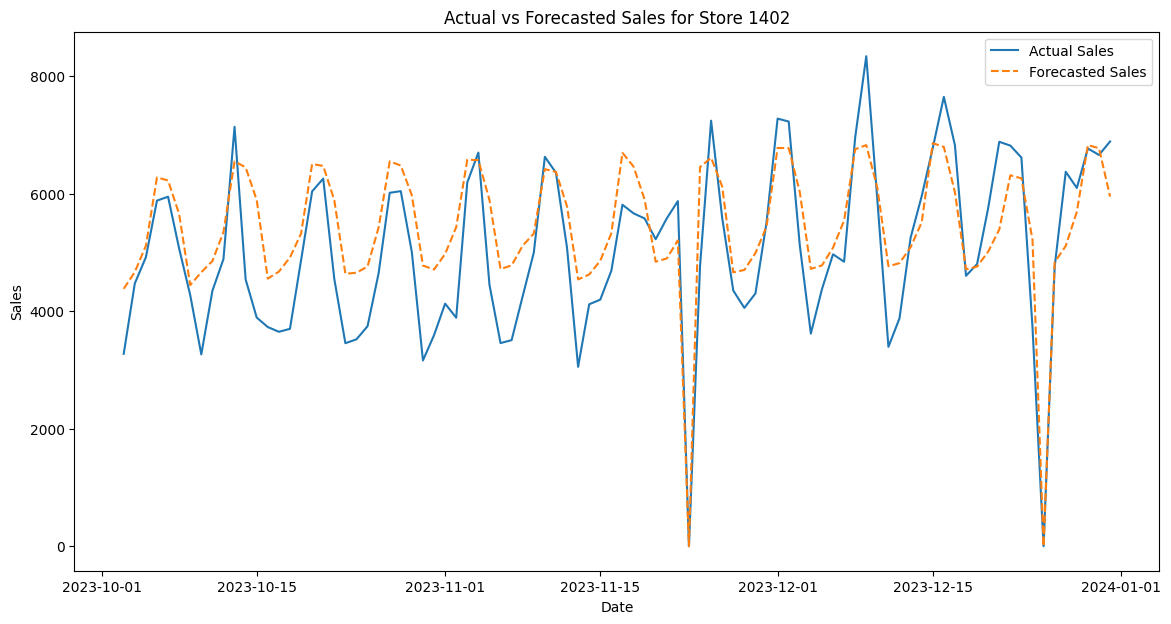

In [278]:
import streamlit as st


# Enter the store key
store_key = st.selectbox('Select Store Key', df['STORE_KEY'].unique())

# Extract actual sales for the selected store
actual_sales = df[df['STORE_KEY'] == store_key].set_index('BUSINESS_DATE')['NET_SALES_FINAL_USD_AMOUNT'].sort_index()[-90:]

# Extract forecasted sales for the selected store
forecast_dis = estimate_proportion_forecast(store_key)
forecasted_sales = forecast_dis['Forecast_Sales']

# Combine actual and forecasted sales into a single DataFrame
combined_sales = pd.concat([actual_sales, forecasted_sales], axis=1)
combined_sales.columns = ['Actual Sales', 'Forecasted Sales']

mape = np.mean(np.abs((actual_sales - forecasted_sales) / actual_sales)) * 100
smape = np.mean(np.abs(actual_sales - forecasted_sales) * 2 / (actual_sales + forecasted_sales)) * 100

st.write(f"MAPE: {mape:.2f}%")
st.write(f"sMAPE: {smape:.2f}%")

# Define dates to exclude
exclude_dates = pd.to_datetime(['2023-11-23', '2023-12-25'])

# Filter out the excluded dates
mask = ~combined_sales.index.isin(exclude_dates)

actual_excl = combined_sales.loc[mask, 'Actual Sales']
mape_excl = np.mean(np.abs((actual_excl - forecasted_sales[mask]) / actual_excl)) * 100
st.write(f"MAPE excluding the 2 spikes: {mape_excl:.2f}%")

# Plot the actual and forecasted sales
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(combined_sales['Actual Sales'], label='Actual Sales')
ax.plot(combined_sales['Forecasted Sales'], label='Forecasted Sales', linestyle='--')
ax.set_title(f'Actual vs Forecasted Sales for Store {store_key}')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
st.pyplot(fig)


In [279]:
!jupyter nbconvert --to script Cluster_Forecasts.ipynb

[NbConvertApp] WARNING | pattern 'Cluster_Forecasts.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execu

In [280]:
with open('requirements.txt', 'w') as f:
    f.write('streamlit\n')
    f.write('pandas\n')
    f.write('numpy\n')
    f.write('matplotlib\n')
    f.write('scikit-learn\n')
    f.write('joblib\n')